# Assignment 2 Code - Amir Sahrani and Sophie Engels

Setting up the notebook and the data.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from ndlib.models.CompositeModel import CompositeModel
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.fftpack import fft, fftfreq
import scipy.stats as stats
from random import random
from glob import glob
import networkx as nx
import ndlib.models.epidemics as ep
from scipy.signal import savgol_filter

#Globally set plot preferences
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif", 
    "font.serif": "Computer Modern Roman"})

plt.rc('axes', titlesize=18)    
plt.rc('axes', labelsize=18)    
plt.rc('xtick', labelsize=16)   
plt.rc('ytick', labelsize=16)    
plt.rc('legend', fontsize=18)

In [5]:
#This is the data we used to create the results.

beta_df = pd.read_csv("data/finalbeta.csv")
gamma_df = pd.read_csv("data/finalgamma.csv")
mu_df = pd.read_csv("data/finalmu.csv")
N_df = pd.read_csv("data/finalN.csv")
gamma_N_df = pd.read_csv("data/finalgamma_N.csv")

# !!THIS WILL DOWNLOAD ABOUT 500MB OF DATA, THIS IS HERE IN CASE SOMEONE WANTS TO RUN THE CODE THEMSELVES. 
# FETCHING AND READING IN THE DATA SHOULD NOT TAKE MORE THAN ABOUT 3 MINUTES!!

# beta_df = pd.read_csv("https://osf.io/download/32acs/")
# gamma_df = pd.read_csv("https://osf.io/download/z7y2c/")
# mu_df = pd.read_csv("https://osf.io/download/y75gx/")
# N_df = pd.read_csv("https://osf.io/download/anqw7/")
# gamma_N_df = pd.read_csv("https://osf.io/download/47ruc/")

Question 1. Stochastic Model Experiments

In [21]:
#Deterministic Model Code

def determinsteSIR(previousState, t, beta, gamma, birth_rate):
    N = np.sum(previousState)
    state = np.empty(3)
    X, Y, Z = previousState
    state[0] = birth_rate - X * birth_rate - X * Y * beta
    state[1] = X * Y * beta - Y * birth_rate - Y * gamma
    state[2] = Y * gamma - Z * birth_rate
    return state


def return_Solved(beta, gamma, mu, N, steps):
    XYZ = [1, 1 / N, 0]
    t = np.linspace(0, 365, steps)

    solved = odeint(determinsteSIR, XYZ, t, (beta, gamma, mu))
    return solved


Gillespie's Algorithm Implementation 

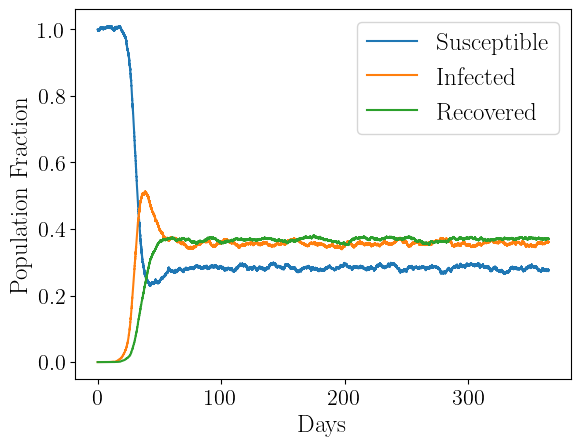

'\ndef run_simulations(number_of_runs, name, param, kwargs):\n    for i in range(number_of_runs):\n        df = pd.DataFrame(stoch_sir(**kwargs))\n        for column in kwargs.keys():\n            df[column] = [kwargs[column] for x in range(len(df))]\n        df["group"] = ["S", "I", "R"]\n        df.to_csv(f"seeddata/{name.capitalize()}{param:.2f}stochasticSIR{i + 1}.csv", index=False)\n'

In [3]:
#Stochastic Model Code

def stoch_sir(XYZ, N, tend, beta, gamma, mu):
    # Columns: SIR, Rows: Events [infect, recovery, birth, death S, death I, death R]
    change_matrix = np.array(
        [[-1, 1, 0],
         [0, -1, 1],
         [1, 0, 0],
         [-1, 0, 0],
         [0, -1, 0],
         [0, 0, -1]
         ])
    current_t = 0
    ts = 0.1
    T = [0]
    S = [XYZ[0]]
    I = [XYZ[1]]
    R = [XYZ[2]]

    while T[current_t] < tend:
        T.append(T[-1] + ts)
        S.append(XYZ[0])
        I.append(XYZ[1])
        R.append(XYZ[2])

        event_rates = ([(beta * XYZ[0] * XYZ[1]) / N, gamma * XYZ[1],
                        mu * N, mu * XYZ[0], mu * XYZ[1], mu * XYZ[2]])

        rand_1 = random()
        rand_2 = random()
        ts = -np.log(rand_1) / (np.sum(event_rates))

        p = rand_2 * np.sum(event_rates)
        event_index = min(np.nonzero(np.ravel(np.cumsum(event_rates) >= p))[0])

        XYZ = XYZ + change_matrix[event_index, :]

        current_t = current_t + 1
    return [T, S, I, R]

XYZ = [10000, 1, 0]
t = np.linspace(0, 365, 1000)
beta = 1 / 2
gamma = 1 / 10
mu = 1 / 60

[T, S, I, R] = stoch_sir(XYZ, 10000, 365, 0.5, 1/14, 0.07)

data_T = np.array(T)
data_S = np.array(S)/10000
data_I = np.array(I)/10000
data_R = np.array(R)/10000

data_T = np.array(T)
data_S = np.array(S)/10000
data_I = np.array(I)/10000
data_R = np.array(R)/10000

plt.plot(data_T, data_S, data_T, data_I, data_T, data_R)
plt.xlabel("Days")
plt.ylabel("Population Fraction")
plt.legend(["Susceptible", "Infected", "Recovered"])
plt.show()


#This block of code was used to run the simulations and collect the data we used.
"""
def run_simulations(number_of_runs, name, param, kwargs):
    for i in range(number_of_runs):
        df = pd.DataFrame(stoch_sir(**kwargs))
        for column in kwargs.keys():
            df[column] = [kwargs[column] for x in range(len(df))]
        df["group"] = ["S", "I", "R"]
        df.to_csv(f"seeddata/{name.capitalize()}{param:.2f}stochasticSIR{i + 1}.csv", index=False)
"""



Investigating Simulation Variability and Covariance

beta = 0.43
Covariance between S and I = -239473.24102769827

beta = 1.69
Covariance between S and I = -74172.7422265998

beta = 2.95
Covariance between S and I = -46288.898423007784



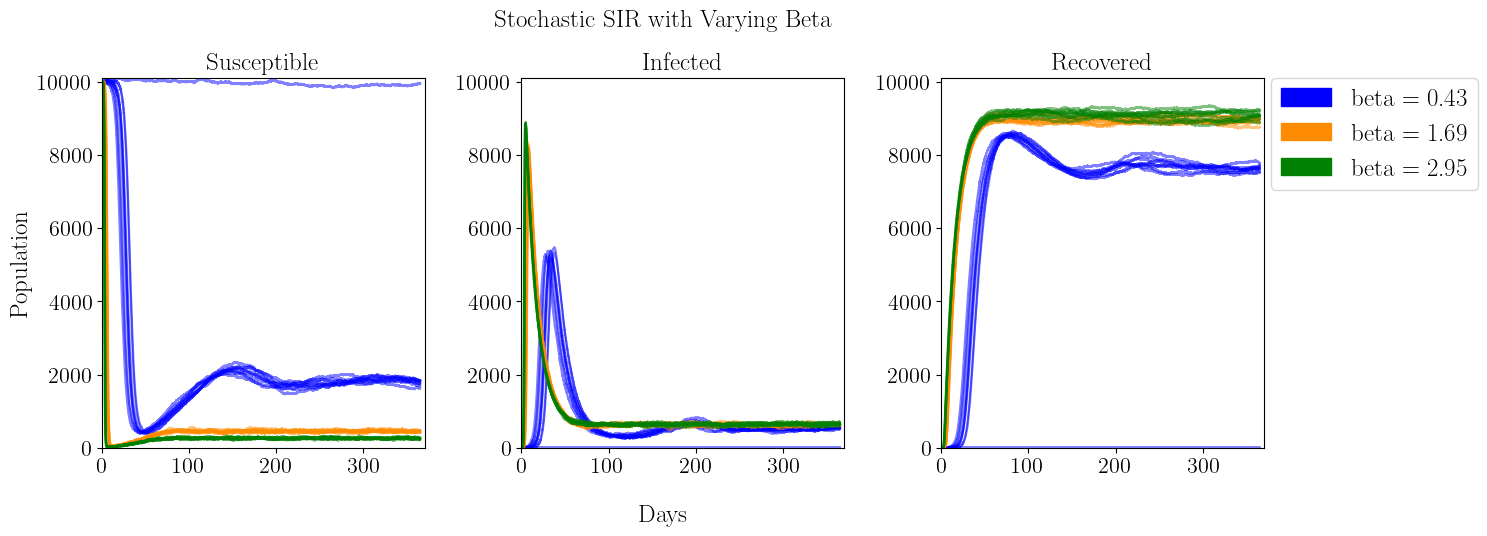

0.0714285714285714
0.005


In [8]:
#Varying Beta Values - Comparing Runs and Calculating Covariance

#Sorting the data 
def sortHelper(x):
    try:
        return float(x)
    except: 
        return 100000
dfs = [beta_df, gamma_df, mu_df, N_df, gamma_N_df]

for df in dfs:
    df.drop(df.columns[df.columns.str.contains('Unnamed')], axis=1, inplace=True) 

sorted_columns = sorted(beta_df.columns, key=sortHelper)

beta_df = beta_df.reindex(columns=sorted_columns)

#Grouping the data by gamma values
grouped = beta_df.groupby(["group"])
grouped_beta = beta_df.groupby(["group", "beta"])
grouped_beta_mean = beta_df.groupby(["group", "beta"]).mean(numeric_only=True)

# Extract column numbers for plotting
numbers = [float(x) for x in beta_df.columns[1:-7:4]]

#Setting the figure
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(15)
color_list = ["blue", "darkorange", "green", "red", "purple", "black"]
color_index = 0
for paramVal in beta_df["beta"].unique()[2::6]:
    new_color = color_list[color_index]
    axs[0].plot(numbers, grouped_beta.get_group(("S", paramVal)).T[1:-7:4], label = f"beta = {paramVal:.{2}f}", color = new_color, alpha = 0.5)
    axs[0].set_title("Susceptible")
    axs[0].set_ylabel("Population")
    axs[1].plot(numbers, grouped_beta.get_group(("I", paramVal)).T[1:-7:4], label = f"beta = {paramVal:.{2}f}", color = new_color, alpha = 0.5)
    axs[1].set_title("Infected")
    axs[2].plot(numbers, grouped_beta.get_group(("R", paramVal)).T[1:-7:4], label = f"beta = {paramVal:.{2}f}", color = new_color, alpha = 0.5)
    axs[2].set_title("Recovered")
    color_index += 1
    
    print(f"beta = {paramVal:.{2}f}")
    cov = np.cov(grouped_beta_mean.loc[("S", paramVal)][1:-7:4].dropna(), grouped_beta_mean.loc[("I", paramVal)][1:-7:4].dropna())
    print(f"Covariance between S and I = {cov[0,1]}")
    print()

legend_handles = [mpatches.Patch(color=color) for color in color_list]
fig.text(0.5, -0.03, "Days", ha='center', va='center', fontsize = 18)
fig.text(0.5, 1.0, "Stochastic SIR with Varying Beta", ha='center', va='center', rotation='horizontal', fontsize = 18)
legend_labels = [f"beta = {paramVal:.{2}f}" for paramVal in beta_df["beta"].unique()[2::6]]
plt.legend(handles = legend_handles, labels = legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.subplots_adjust(wspace = 0.3)
plt.show()

print(beta_df["gamma"][0])
print(beta_df["mu"][0])

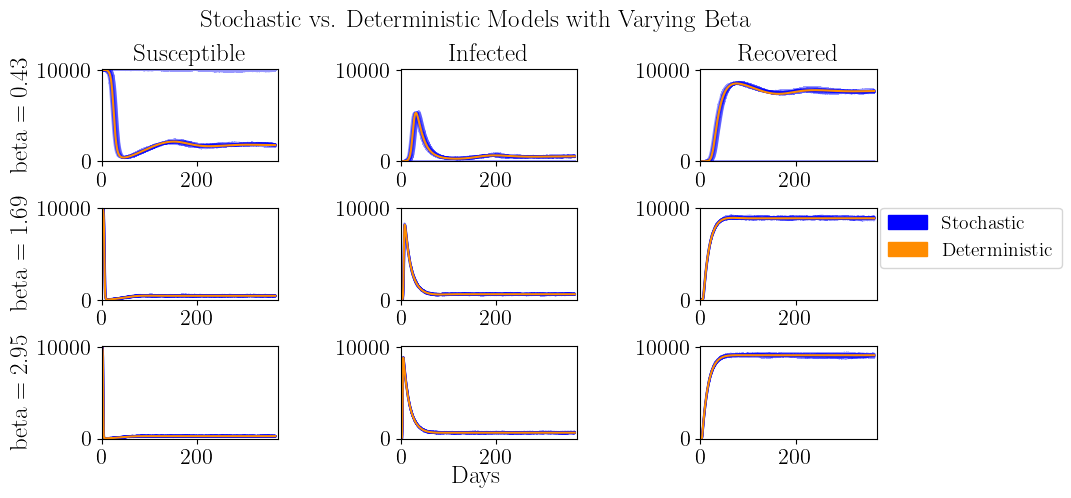

In [9]:
#Varying Beta Values - Comparison with Deterministic Model

#Setting the figure
fig, axs = plt.subplots(3, 3)
fig.set_figwidth(10)

# Plotting the data
t1 = np.linspace(0, 365, len(numbers))

for i in range(3): 
    paramVals = beta_df["beta"].unique()[2::6]
    solved = odeint(determinsteSIR, [1, 0.0001, 0], t1, (paramVals[i], beta_df["gamma"][0], beta_df["mu"][0]))*10000
    axs[i,0].plot(numbers, grouped_beta.get_group(("S", paramVals[i])).T[1:-7:4], color = "blue", alpha = 0.4)
    axs[i,0].plot(numbers, solved[:,0], color = "darkorange")
    
    axs[i,1].plot(numbers, grouped_beta.get_group(("I", paramVals[i])).T[1:-7:4], color = "blue", alpha = 0.4)
    axs[i,1].plot(numbers, solved[:,1], color = "darkorange")
     
    axs[i,2].plot(numbers, grouped_beta.get_group(("R", paramVals[i])).T[1:-7:4], color = "blue", alpha = 0.4)
    axs[i,2].plot(numbers, solved[:,2], color = "darkorange")
    
    axs[i,0].set_ylabel(f"beta = {round(paramVals[i], 2)}")
    
    
axs[0,0].set_title("Susceptible", fontsize = 18)
axs[0,1].set_title("Infected", fontsize = 18)
axs[0,2].set_title("Recovered", fontsize = 18)

legend_handles = [mpatches.Patch(color=color) for color in color_list[:2]]
fig.text(0.5, 0.03, "Days", ha='center', va='center', fontsize = 18)
fig.text(0.5, 0.98, "Stochastic vs. Deterministic Models with Varying Beta", ha='center', va='center', rotation='horizontal', fontsize = 18)
legend_labels = ["Stochastic", "Deterministic"]
plt.rc('legend', fontsize=14)
plt.legend(labels = legend_labels, handles = legend_handles, bbox_to_anchor=(1.02, 2.5), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.subplots_adjust(wspace = 0.7, hspace = 0.5)
plt.show()

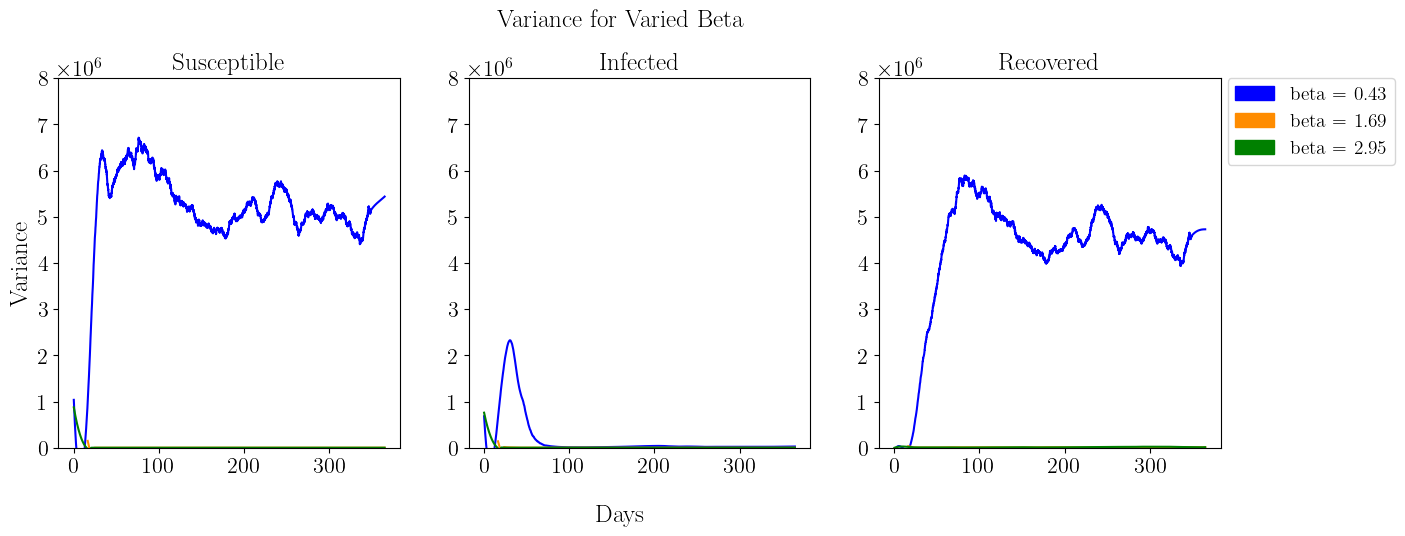

In [10]:
#Varying Beta - Plotting Variance with Time

numbers = [float(x) for x in beta_df.columns[1:-7:4]]
grouped_beta_var = beta_df.groupby(["group", "beta"]).var(numeric_only=True)

fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(15)
color_index = 0
for paramVal in beta_df["beta"].unique()[2::6]:
    var_s = grouped_beta_var.loc[("S", paramVal)][1:-7:4]
    var_i = grouped_beta_var.loc[("I", paramVal)][1:-7:4]
    var_r = grouped_beta_var.loc[("R", paramVal)][1:-7:4]
    
    smoothed_var_s = savgol_filter(var_s, window_length=800, polyorder=3)
    smoothed_var_i = savgol_filter(var_i, window_length=800, polyorder=3)
    smoothed_var_r = savgol_filter(var_r, window_length=800, polyorder=3)
    
    new_color = color_list[color_index]
    axs[0].plot(numbers[:-1], smoothed_var_s, label = f"beta = {paramVal:.{2}f}", color = new_color)
    axs[0].set_title("Susceptible")
    axs[0].set_ylabel("Variance")
    axs[1].plot(numbers[:-1], smoothed_var_i, label = f"beta = {paramVal:.{2}f}", color = new_color)
    axs[1].set_title("Infected")
    axs[2].plot(numbers[:-1], smoothed_var_r, label = f"beta = {paramVal:.{2}f}", color = new_color)
    axs[2].set_title("Recovered")
    color_index += 1

legend_handles = [mpatches.Patch(color=color) for color in color_list]
fig.text(0.5, -0.03, "Days", ha='center', va='center', fontsize = 18)
fig.text(0.5, 1.0, "Variance for Varied Beta", ha='center', va='center', rotation='horizontal', fontsize = 18)
legend_labels = [f"beta = {paramVal:.{2}f}" for paramVal in np.sort(beta_df["beta"].unique()[2::6])]
plt.legend(handles = legend_handles, labels = legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.setp(axs, ylim=(0,8000000))
plt.show()

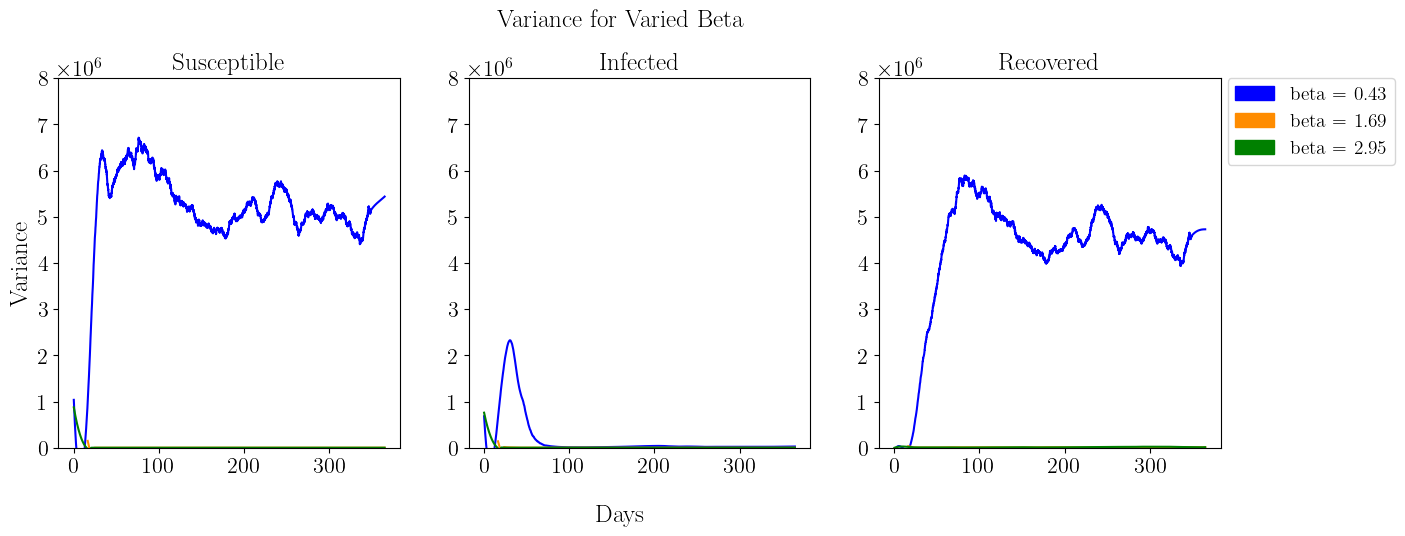

In [11]:
#Varying Gamma - Comparing Runs and Calculating Covariance

numbers = [float(x) for x in beta_df.columns[1:-7:4]]
grouped_beta_var = beta_df.groupby(["group", "beta"]).var(numeric_only=True)

fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(15)
color_index = 0
for paramVal in beta_df["beta"].unique()[2::6]:
    var_s = grouped_beta_var.loc[("S", paramVal)][1:-7:4]
    var_i = grouped_beta_var.loc[("I", paramVal)][1:-7:4]
    var_r = grouped_beta_var.loc[("R", paramVal)][1:-7:4]
    
    smoothed_var_s = savgol_filter(var_s, window_length=800, polyorder=3)
    smoothed_var_i = savgol_filter(var_i, window_length=800, polyorder=3)
    smoothed_var_r = savgol_filter(var_r, window_length=800, polyorder=3)
    
    new_color = color_list[color_index]
    axs[0].plot(numbers[:-1], smoothed_var_s, label = f"beta = {paramVal:.{2}f}", color = new_color)
    axs[0].set_title("Susceptible")
    axs[0].set_ylabel("Variance")
    axs[1].plot(numbers[:-1], smoothed_var_i, label = f"beta = {paramVal:.{2}f}", color = new_color)
    axs[1].set_title("Infected")
    axs[2].plot(numbers[:-1], smoothed_var_r, label = f"beta = {paramVal:.{2}f}", color = new_color)
    axs[2].set_title("Recovered")
    color_index += 1

legend_handles = [mpatches.Patch(color=color) for color in color_list]
fig.text(0.5, -0.03, "Days", ha='center', va='center', fontsize = 18)
fig.text(0.5, 1.0, "Variance for Varied Beta", ha='center', va='center', rotation='horizontal', fontsize = 18)
legend_labels = [f"beta = {paramVal:.{2}f}" for paramVal in np.sort(beta_df["beta"].unique()[2::6])]
plt.legend(handles = legend_handles, labels = legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.setp(axs, ylim=(0,8000000))
plt.show()

gamma = 0.04
Covariance between S and I = -538443.9043763296

gamma = 0.19
Covariance between S and I = -96048.31794408266

gamma = 0.37
Covariance between S and I = -983.1831858436726



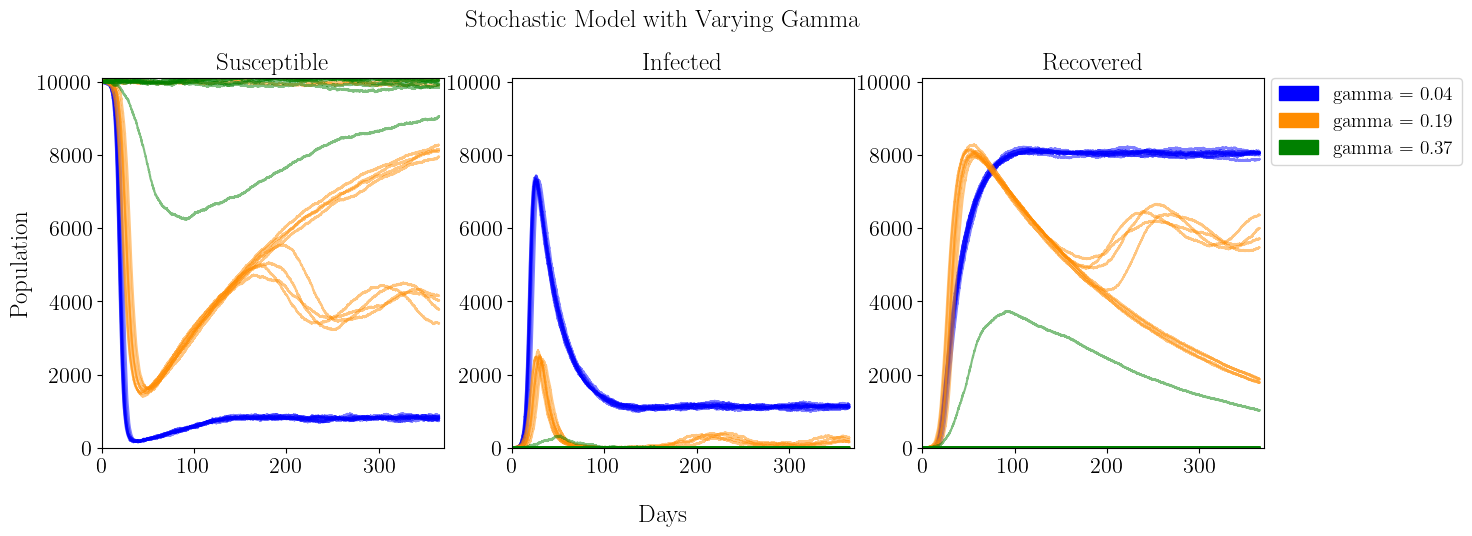

0.5
0.005


In [13]:
#Varying Gamma - Comparing Runs and Calculating Covariance

#Grouping the data by gamma values
grouped = gamma_df.groupby(["group"])
grouped_gamma = gamma_df.groupby(["group", "gamma"])
grouped_gamma_mean = gamma_df.groupby(["group", "gamma"]).mean(numeric_only=True)

# Extract column numbers for plotting
numbers = [float(x) for x in gamma_df.columns[1:-7:4]]

#Setting the figure
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(15)

# Plotting the data
color_list = ["blue", "darkorange", "green", "red", "purple", "black"]
color_index = 0
for paramVal in gamma_df["gamma"].unique()[2::6]:
    new_color = color_list[color_index]
    axs[0].plot(numbers, grouped_gamma.get_group(("S", paramVal)).T[1:-7:4], color = new_color, alpha = 0.5)
    axs[0].set_title("Susceptible")
    axs[0].set_ylabel("Population")
    axs[1].plot(numbers, grouped_gamma.get_group(("I", paramVal)).T[1:-7:4], color = new_color, alpha = 0.5)
    axs[1].set_title("Infected")
    axs[2].plot(numbers, grouped_gamma.get_group(("R", paramVal)).T[1:-7:4], color = new_color, alpha = 0.5)
    axs[2].set_title("Recovered")
    color_index += 1
    
    print(f"gamma = {paramVal:.{2}f}")
    cov = np.cov(grouped_gamma_mean.loc[("S", paramVal)][1:-7:4].dropna(), grouped_gamma_mean.loc[("I", paramVal)][1:-7:4].dropna())
    print(f"Covariance between S and I = {cov[0,1]}")
    print()

legend_handles = [mpatches.Patch(color=color) for color in color_list]
fig.text(0.5, -0.03, "Days", ha='center', va='center', fontsize = 18)
fig.text(0.5, 1.0, "Stochastic Model with Varying Gamma", ha='center', va='center', rotation='horizontal', fontsize = 18)
legend_labels = [f"gamma = {paramVal:.{2}f}" for paramVal in gamma_df["gamma"].unique()[2::6]]
plt.legend(handles = legend_handles, labels = legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.show()

print(gamma_df["beta"][0])
print(gamma_df["mu"][0])

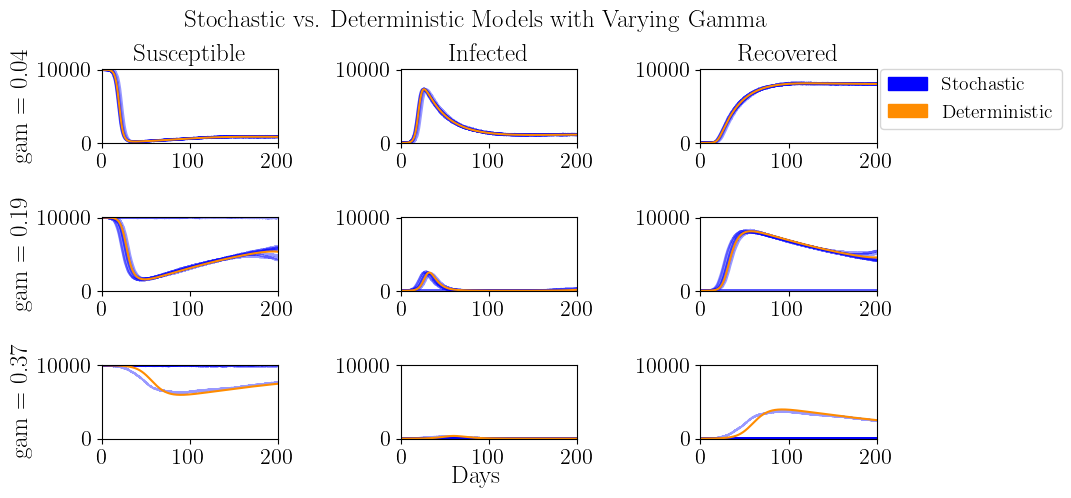

In [14]:
#Varying Gamma - Comparison with Deterministic Model 

#Setting the figure
fig, axs = plt.subplots(3, 3)
fig.set_figwidth(10)

# Plotting the data
t1 = np.linspace(0, 365, len(numbers))

for i in range(3): 
    paramVals = gamma_df["gamma"].unique()[2::6]
    solved = odeint(determinsteSIR, [1, 0.0001, 0], t1, (gamma_df["beta"][0], paramVals[i], gamma_df["mu"][0]))*10000
    axs[i,0].plot(numbers, grouped_gamma.get_group(("S", paramVals[i])).T[1:-7:4], color = "blue", alpha = 0.4)
    axs[i,0].plot(numbers, solved[:,0], color = "darkorange")
    
    axs[i,1].plot(numbers, grouped_gamma.get_group(("I", paramVals[i])).T[1:-7:4], color = "blue", alpha = 0.4)
    axs[i,1].plot(numbers, solved[:,1], color = "darkorange")
     
    axs[i,2].plot(numbers, grouped_gamma.get_group(("R", paramVals[i])).T[1:-7:4], color = "blue", alpha = 0.4)
    axs[i,2].plot(numbers, solved[:,2], color = "darkorange")
    
    axs[i,0].set_ylabel(f"gam = {round(paramVals[i], 2)}")
    
    
axs[0,0].set_title("Susceptible", fontsize = 18)
axs[0,1].set_title("Infected", fontsize = 18)
axs[0,2].set_title("Recovered", fontsize = 18)

legend_handles = [mpatches.Patch(color=color) for color in color_list[:2]]
fig.text(0.5, 0.03, "Days", ha='center', va='center', fontsize = 18)
fig.text(0.5, 0.98, "Stochastic vs. Deterministic Models with Varying Gamma", ha='center', va='center', rotation='horizontal', fontsize = 18)
plt.rc('legend', fontsize=14)
legend_labels = ["Stochastic", "Deterministic"]
plt.legend(labels = legend_labels, handles = legend_handles, bbox_to_anchor=(1.02, 5), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,200), ylim=(0,10100))
plt.subplots_adjust(wspace = 0.7, hspace = 1)
plt.show()

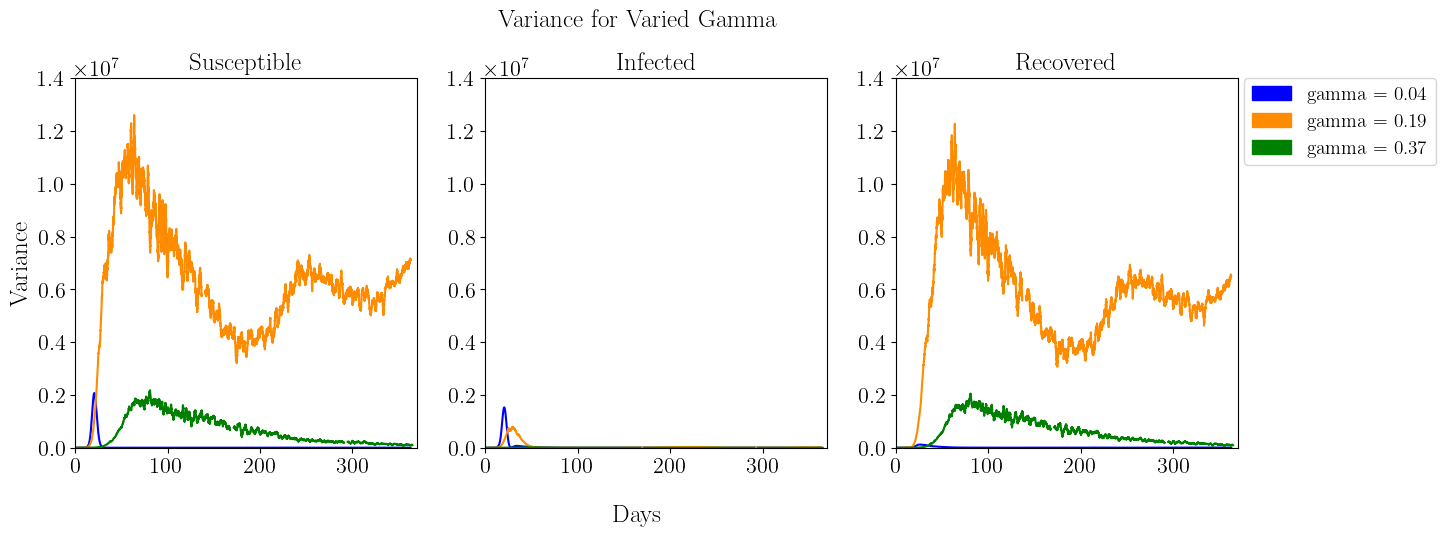

In [15]:
#Varying Gamma - Plotting Variance with Time

numbers = [float(x) for x in gamma_df.columns[1:-7:4]]
grouped_gamma_var = gamma_df.groupby(["group", "gamma"]).var(numeric_only=True)

fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(15)
color_index = 0
for paramVal in np.sort(gamma_df["gamma"].unique()[2::6]):
    var_s = grouped_gamma_var.loc[("S", paramVal)][1:-7:4]
    var_i = grouped_gamma_var.loc[("I", paramVal)][1:-7:4]
    var_r = grouped_gamma_var.loc[("R", paramVal)][1:-7:4]
    
    smoothed_var_s = savgol_filter(var_s, window_length=100, polyorder=3)
    smoothed_var_i = savgol_filter(var_i, window_length=100, polyorder=3)
    smoothed_var_r = savgol_filter(var_r, window_length=100, polyorder=3)
    
    new_color = color_list[color_index]
    axs[0].plot(numbers, smoothed_var_s, label = f"gamma = {paramVal:.{2}f}", color = new_color)
    axs[0].set_title("Susceptible")
    axs[0].set_ylabel("Variance")
    axs[1].plot(numbers, smoothed_var_i, label = f"gamma = {paramVal:.{2}f}", color = new_color)
    axs[1].set_title("Infected")
    axs[2].plot(numbers, smoothed_var_r, label = f"gamma = {paramVal:.{2}f}", color = new_color)
    axs[2].set_title("Recovered")
    color_index += 1

legend_handles = [mpatches.Patch(color=color) for color in color_list]
fig.text(0.5, -0.03, "Days", ha='center', va='center', fontsize = 18)
fig.text(0.5, 1.0, "Variance for Varied Gamma", ha='center', va='center', rotation='horizontal', fontsize = 18)
legend_labels = [f"gamma = {paramVal:.{2}f}" for paramVal in np.sort(gamma_df["gamma"].unique()[2::6])]
plt.legend(handles = legend_handles, labels = legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,14000000))
plt.show()
plt.show()

mu = 0.01
Covariance between S and I = -496892.7016567304

mu = 0.07
Covariance between S and I = -624120.623342227



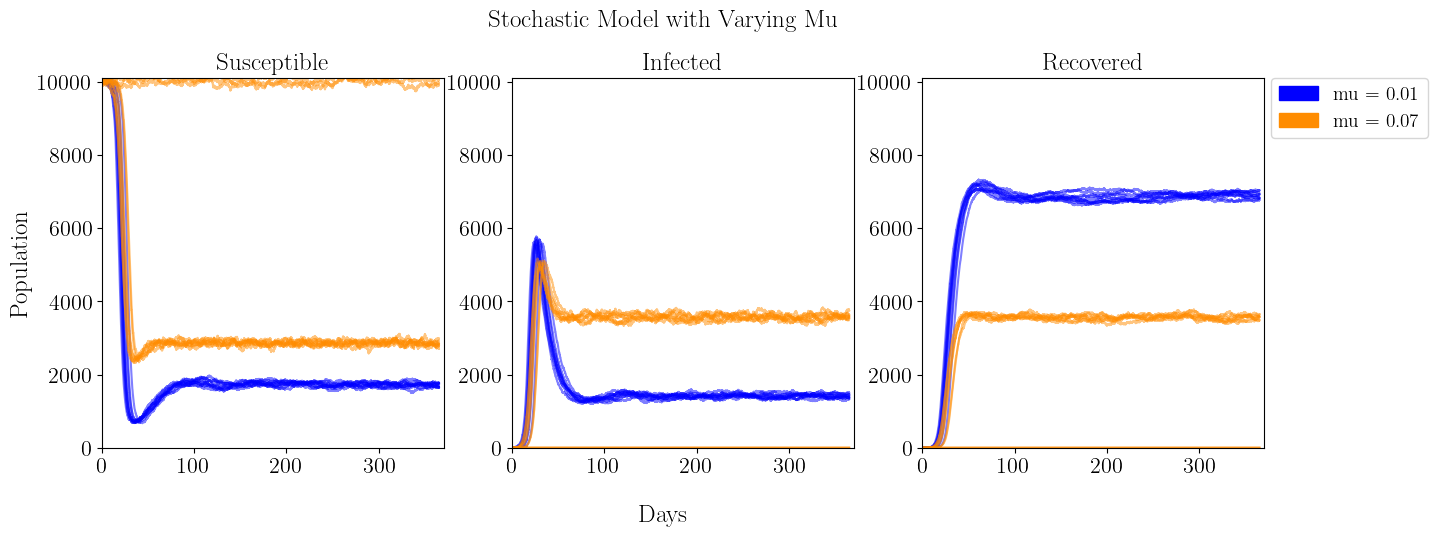

In [16]:
#Varying Mu - Comparing Runs and Calculating Covariance

#Grouping the data by mu values
grouped = mu_df.groupby(["group"])
grouped_mu = mu_df.groupby(["group", "mu"])
grouped_mu_mean = mu_df.groupby(["group", "mu"]).mean(numeric_only=True)

# Extract column numbers for plotting
numbers = [float(x) for x in mu_df.columns[1:-7:4]]

#Setting the figure
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(15)

# Plotting the data
color_list = ["blue", "darkorange", "green", "red", "purple", "black"]
color_index = 0
for paramVal in np.sort(mu_df["mu"].unique()[::6]):
    new_color = color_list[color_index]
    axs[0].plot(numbers, grouped_mu.get_group(("S", paramVal)).T[1:-7:4], label = f"mu = {paramVal:.{2}f}", color = new_color, alpha = 0.5)
    axs[0].set_title("Susceptible")
    axs[0].set_ylabel("Population")
    axs[1].plot(numbers, grouped_mu.get_group(("I", paramVal)).T[1:-7:4], label = f"mu = {paramVal:.{2}f}", color = new_color, alpha = 0.5)
    axs[1].set_title("Infected")
    axs[2].plot(numbers, grouped_mu.get_group(("R", paramVal)).T[1:-7:4], label = f"mu = {paramVal:.{2}f}", color = new_color, alpha = 0.5)
    axs[2].set_title("Recovered")
    color_index += 1
    
    print(f"mu = {paramVal:.{2}f}")
    cov = np.cov(grouped_mu_mean.loc[("S", paramVal)][1:-7:4].dropna(), grouped_mu_mean.loc[("I", paramVal)][1:-7:4].dropna())
    print(f"Covariance between S and I = {cov[0,1]}")
    print()

legend_handles = [mpatches.Patch(color=color) for color in color_list]
fig.text(0.5, -0.03, "Days", ha='center', va='center', fontsize = 18)
fig.text(0.5, 1.0, "Stochastic Model with Varying Mu", ha='center', va='center', rotation='horizontal', fontsize = 18)
legend_labels = [f"mu = {paramVal:.{2}f}" for paramVal in np.sort(mu_df["mu"].unique()[::6])]
plt.legend(handles = legend_handles, labels = legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.show()

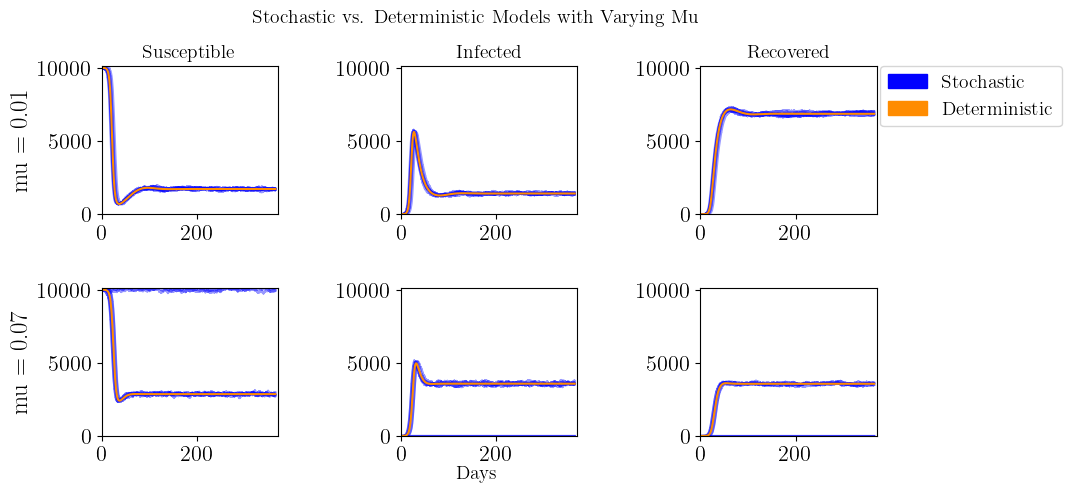

In [17]:
#Varying Mu - Comparison with Deterministic Model 

#Setting the figure
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(10)

# Plotting the data
t1 = np.linspace(0, 365, len(numbers))

for i in range(2): 
    paramVals = mu_df["mu"].unique()[::6]
    solved = odeint(determinsteSIR, [1, 0.0001, 0], t1, (mu_df["beta"][0], mu_df["gamma"][0], paramVals[i]))*10000
    axs[i,0].plot(numbers, grouped_mu.get_group(("S", paramVals[i])).T[1:-7:4], color = "blue", alpha = 0.4)
    axs[i,0].plot(numbers, solved[:,0], color = "darkorange")
    
    axs[i,1].plot(numbers, grouped_mu.get_group(("I", paramVals[i])).T[1:-7:4], color = "blue", alpha = 0.4)
    axs[i,1].plot(numbers, solved[:,1], color = "darkorange")
     
    axs[i,2].plot(numbers, grouped_mu.get_group(("R", paramVals[i])).T[1:-7:4], color = "blue", alpha = 0.4)
    axs[i,2].plot(numbers, solved[:,2], color = "darkorange")
    
    axs[i,0].set_ylabel(f"mu = {round(paramVals[i], 2)}")
    
    
axs[0,0].set_title("Susceptible", fontsize = 14)
axs[0,1].set_title("Infected", fontsize = 14)
axs[0,2].set_title("Recovered", fontsize = 14)

legend_handles = [mpatches.Patch(color=color) for color in color_list[:2]]
fig.text(0.5, 0.03, "Days", ha='center', va='center', fontsize = 14)
fig.text(0.5, 0.98, "Stochastic vs. Deterministic Models with Varying Mu", ha='center', va='center', rotation='horizontal', fontsize = 14)
legend_labels = ["Stochastic", "Deterministic"]
plt.legend(labels = legend_labels, handles = legend_handles, bbox_to_anchor=(1.02, 2.5), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.subplots_adjust(wspace = 0.7, hspace = 0.5)
plt.show()

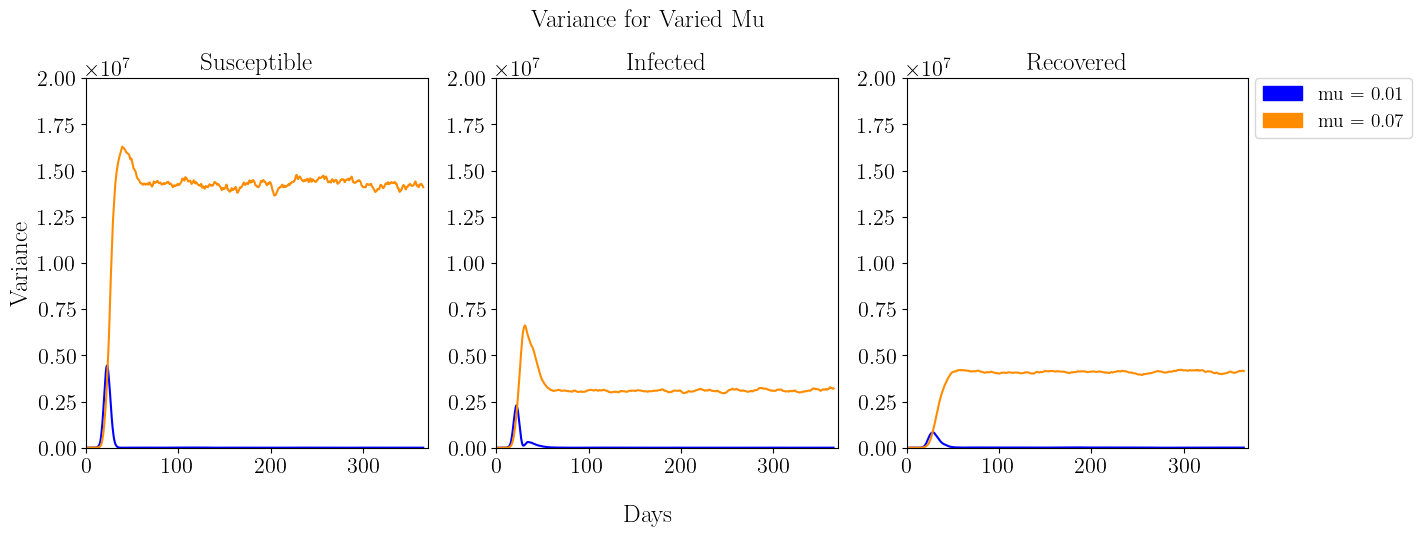

In [18]:
#Varying Mu - Plotting Variance with Time

numbers = [float(x) for x in mu_df.columns[1:-7:4]]
grouped_mu_var = mu_df.groupby(["group", "mu"]).var(numeric_only=True)

fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(15)
color_index = 0
for paramVal in mu_df["mu"].unique()[::5]:
    var_s = grouped_mu_var.loc[("S", paramVal)][1:-7:4]
    var_i = grouped_mu_var.loc[("I", paramVal)][1:-7:4]
    var_r = grouped_mu_var.loc[("R", paramVal)][1:-7:4]
    
    smoothed_var_s = savgol_filter(var_s, window_length=50, polyorder=3)
    smoothed_var_i = savgol_filter(var_i, window_length=50, polyorder=3)
    smoothed_var_r = savgol_filter(var_r, window_length=50, polyorder=3)
    
    new_color = color_list[color_index]
    axs[0].plot(numbers, smoothed_var_s, color = new_color)
    axs[0].set_title("Susceptible")
    axs[0].set_ylabel("Variance")
    axs[1].plot(numbers, smoothed_var_i, color = new_color)
    axs[1].set_title("Infected")
    axs[2].plot(numbers, smoothed_var_r, color = new_color)
    axs[2].set_title("Recovered")
    color_index += 1

legend_handles = [mpatches.Patch(color=color) for color in color_list]
fig.text(0.5, -0.03, "Days", ha='center', va='center', fontsize = 18)
fig.text(0.5, 1.0, "Variance for Varied Mu", ha='center', va='center', rotation='horizontal', fontsize = 18)
legend_labels = [f"mu = {paramVal:.{2}f}" for paramVal in np.sort(mu_df["mu"].unique()[::6])]
plt.legend(handles = legend_handles, labels = legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,20000000))
plt.show()

Stochastic Resonance and Increased Transients

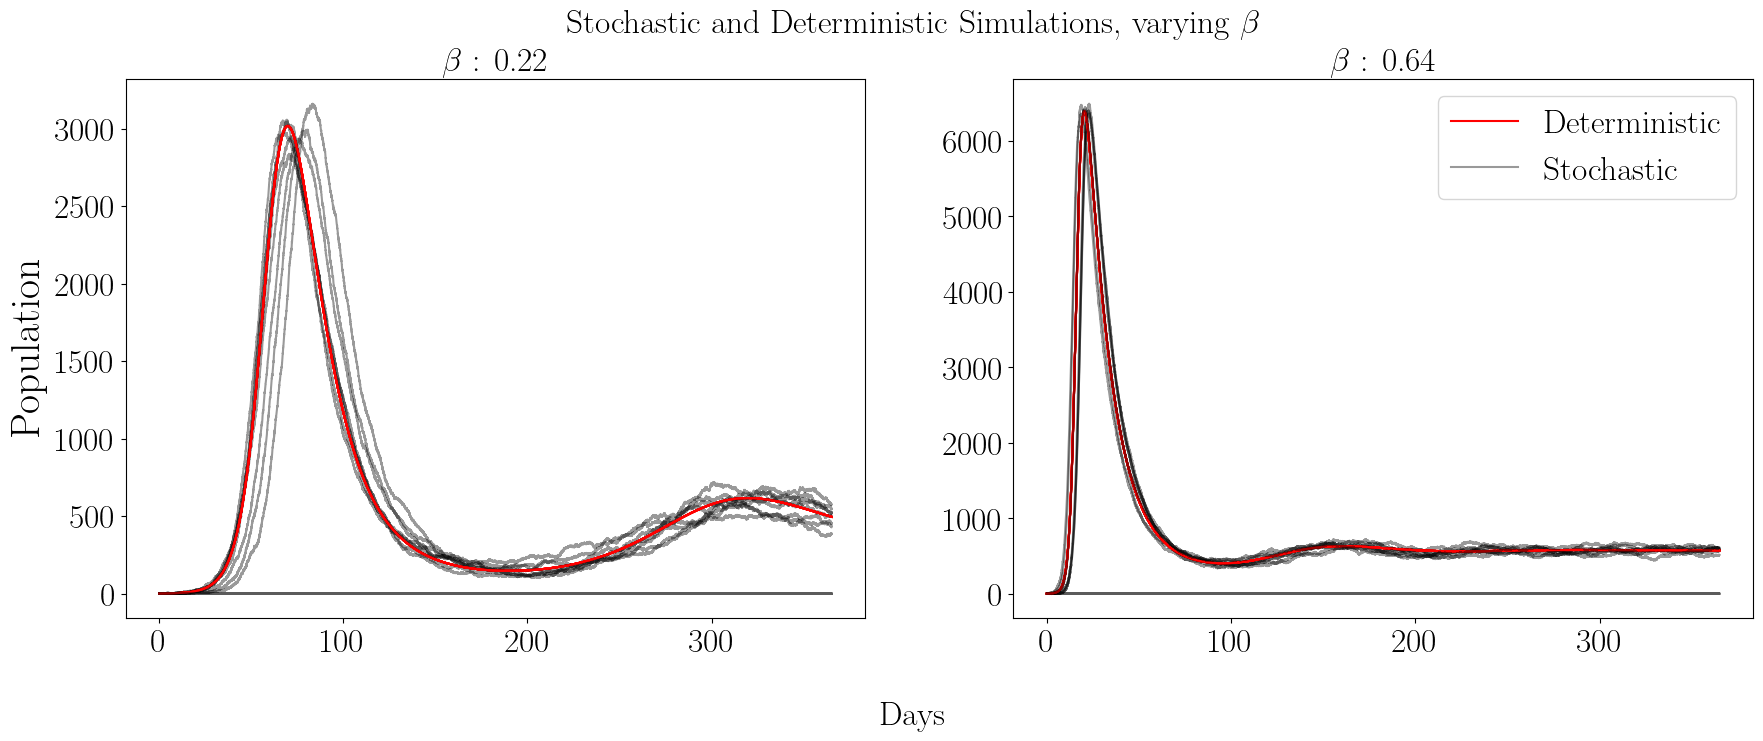

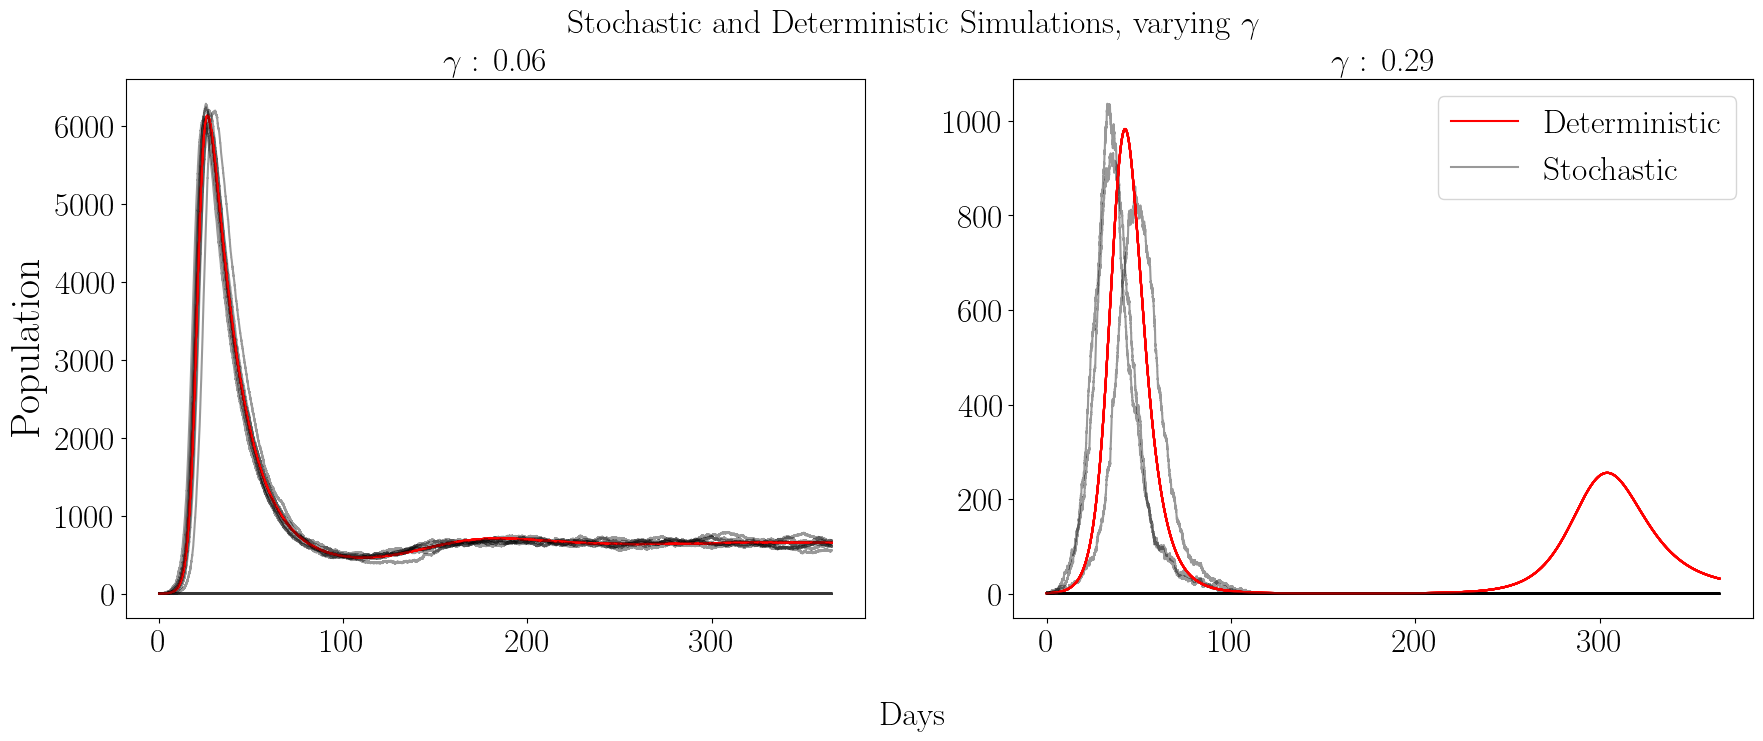

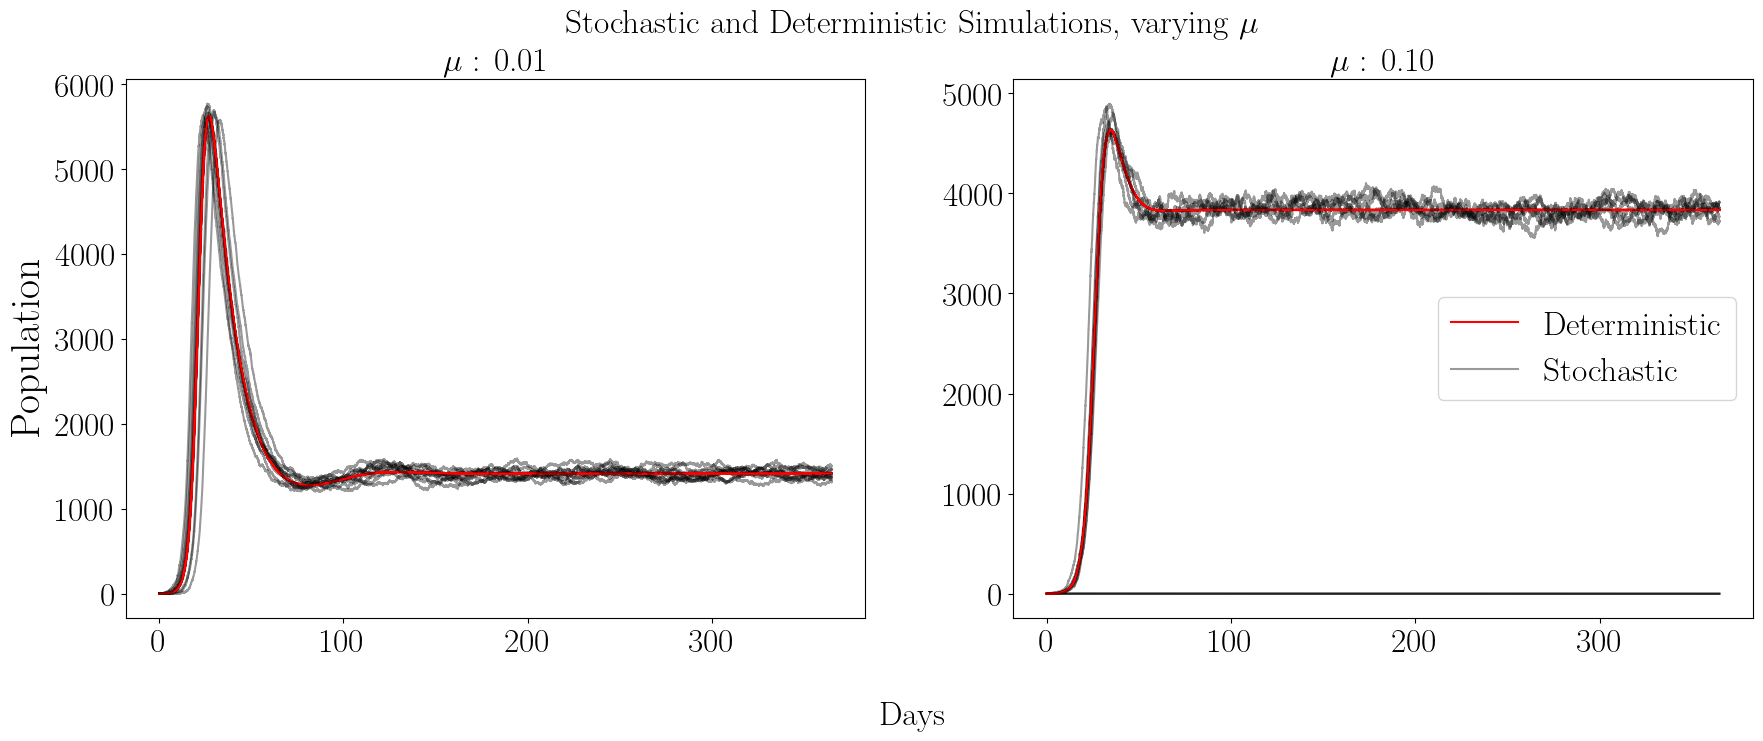

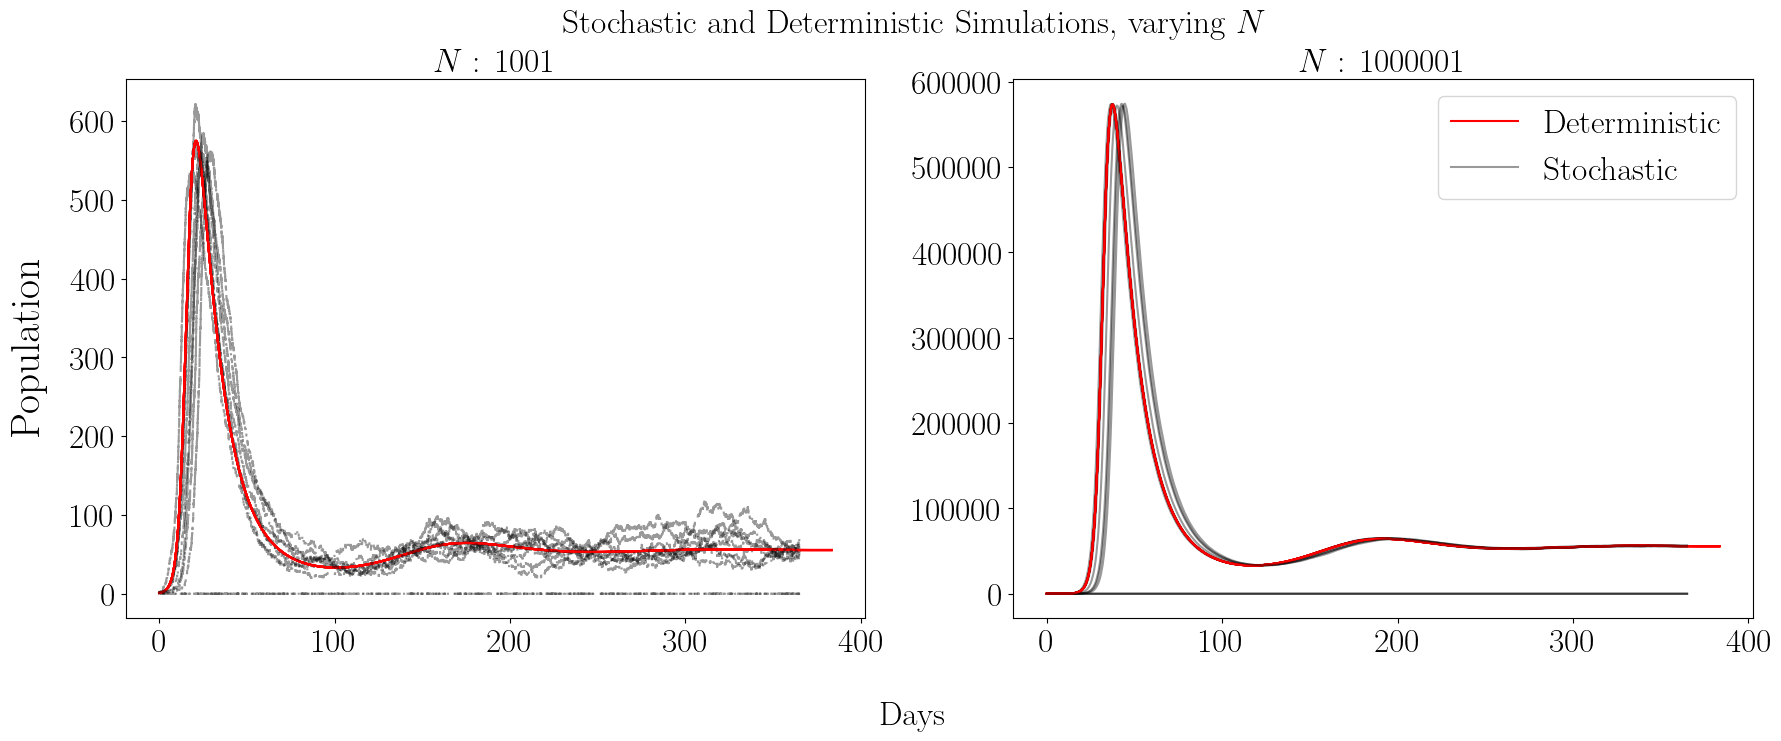

In [24]:
#Comparing Transients for Different Parameter Values

plt.rc('axes', titlesize=24)    
plt.rc('axes', labelsize=24)    
plt.rc('xtick', labelsize=24)   
plt.rc('ytick', labelsize=24)    
plt.rc('legend', fontsize=24)

def plt_row(df, param):
    values = df[param].unique()
    values.sort()
    idx = np.linspace(0, len(values)-1, 2).astype(int)
    
    for plot, current_param in enumerate(values[idx]):
        intervals = [float(x) for x in df.columns[1:-6]]
        filtered_df = df.loc[(df[param] == current_param) & (df["group"] == "I")]
        
        for i in range(10):
            kwargs = {}
            parameters = ["beta","gamma","mu","N"]
            parameters.remove(param)
            
            for x in parameters:
                kwargs[x] = df[x].unique()[0]
            kwargs[param] = current_param
            
            determinist_data = return_Solved(**kwargs, steps = len(intervals))[:, 1] * kwargs["N"]
            mult = current_param ** (param == "N") #If we are currently plotting for change in N, we need to multiply by N because the data was normalized to 1
            if i == 0:
                axs[plot].plot(intervals, determinist_data, color="r",label = "Deterministic")
                axs[plot].plot(intervals, filtered_df.iloc[i, 1:-6] * mult, color ="black", alpha= 0.4, label = "Stochastic")
            else:
                axs[plot].plot(intervals, determinist_data, color="r")
                axs[plot].plot(intervals, filtered_df.iloc[i, 1:-6] * mult, color ="black", alpha= 0.4)
            if param == "N":
                axs[plot].set_title(f"${param}$  : {int(current_param)}")
            else:
                axs[plot].set_title(f"$\{param}$  : {current_param:.2f}")

fig, axs = plt.subplots(1, 2, figsize=(21, 7))
axs = axs.ravel()
plt_row(beta_df.loc[(0.1 < beta_df["beta"]) & (beta_df["beta"] < 0.85)], "beta")
fig.suptitle("Stochastic and Deterministic Simulations, varying $\\beta$", fontsize = 24)
fig.text(0.5, -0.03, "Days", ha='center', va='center', fontsize = 24)
fig.text(0.07, 0.5, 'Population', va='center', rotation='vertical', fontsize = 30)
axs[1].legend(loc="best")

fig, axs = plt.subplots(1, 2, figsize=(21, 7))
axs = axs.ravel()
plt_row(gamma_df.loc[(0.05 < gamma_df["gamma"]) & (gamma_df["gamma"] < 0.3 )], "gamma")
fig.suptitle("Stochastic and Deterministic Simulations, varying $\gamma$", fontsize = 24)
fig.text(0.5, -0.03, "Days", ha='center', va='center', fontsize = 24)
fig.text(0.07, 0.5, 'Population', va='center', rotation='vertical', fontsize = 30)
axs[1].legend(loc="best")

fig, axs = plt.subplots(1, 2, figsize=(21, 7))
axs = axs.ravel()
plt_row(mu_df, "mu")
fig.suptitle("Stochastic and Deterministic Simulations, varying $\mu$", fontsize = 24)
fig.text(0.5, -0.03, "Days", ha='center', va='center', fontsize = 24)
fig.text(0.07, 0.5, 'Population', va='center', rotation='vertical', fontsize = 30)
axs[1].legend(loc="best")

fig, axs = plt.subplots(1, 2, figsize=(21, 7))
axs = axs.ravel()
plt_row(N_df.loc[N_df["N"] > 999], "N")
fig.suptitle("Stochastic and Deterministic Simulations, varying $N$", fontsize = 24)
fig.text(0.5, -0.03, "Days", ha='center', va='center', fontsize = 24)
fig.text(0.07, 0.5, 'Population', va='center', rotation='vertical', fontsize = 30)
axs[1].legend(loc="best")


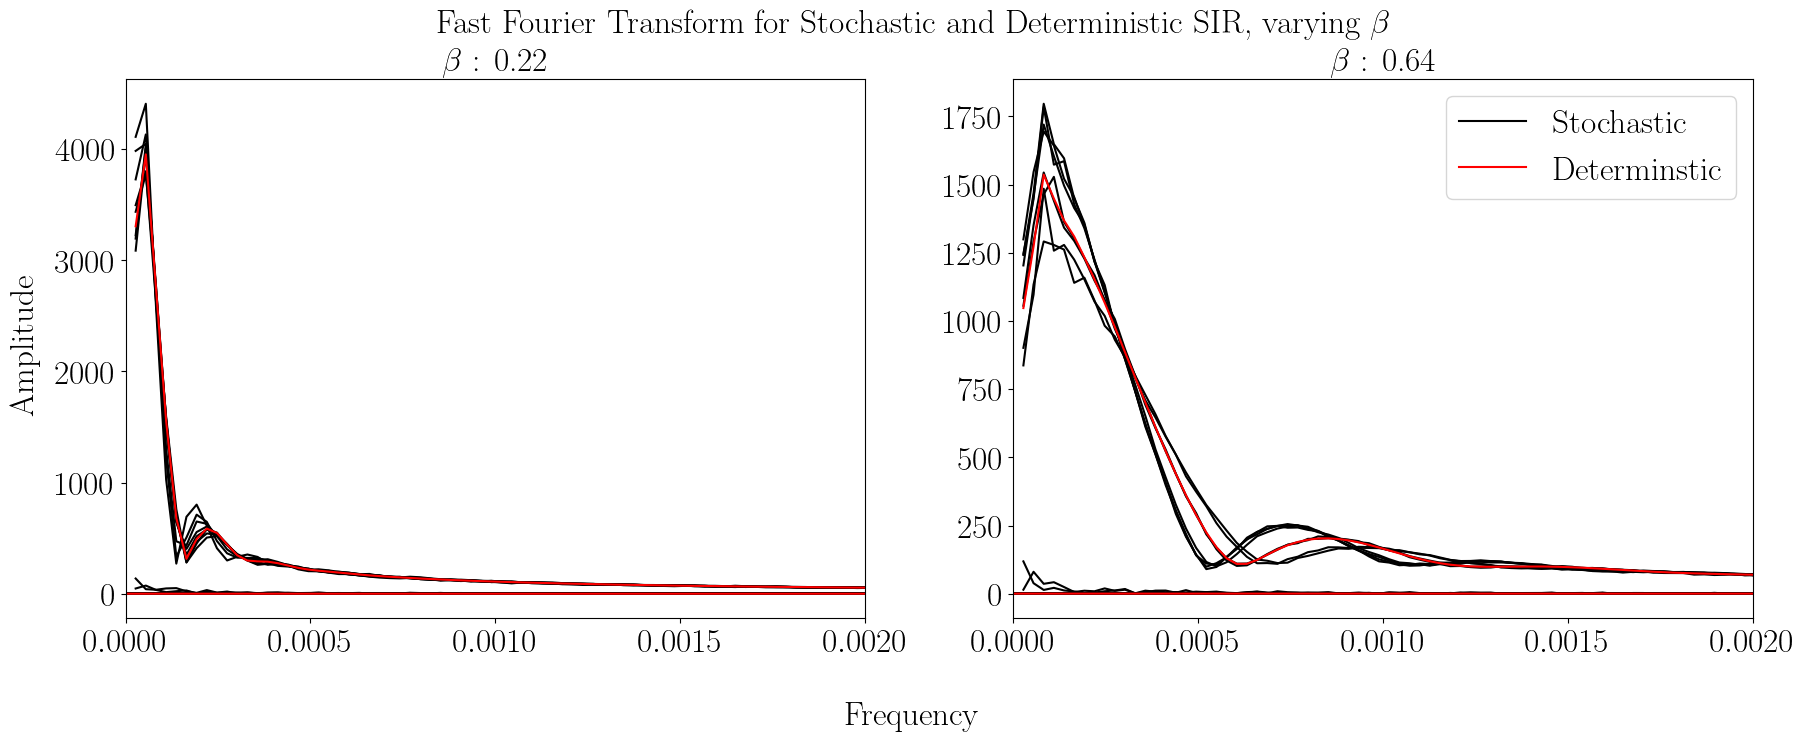

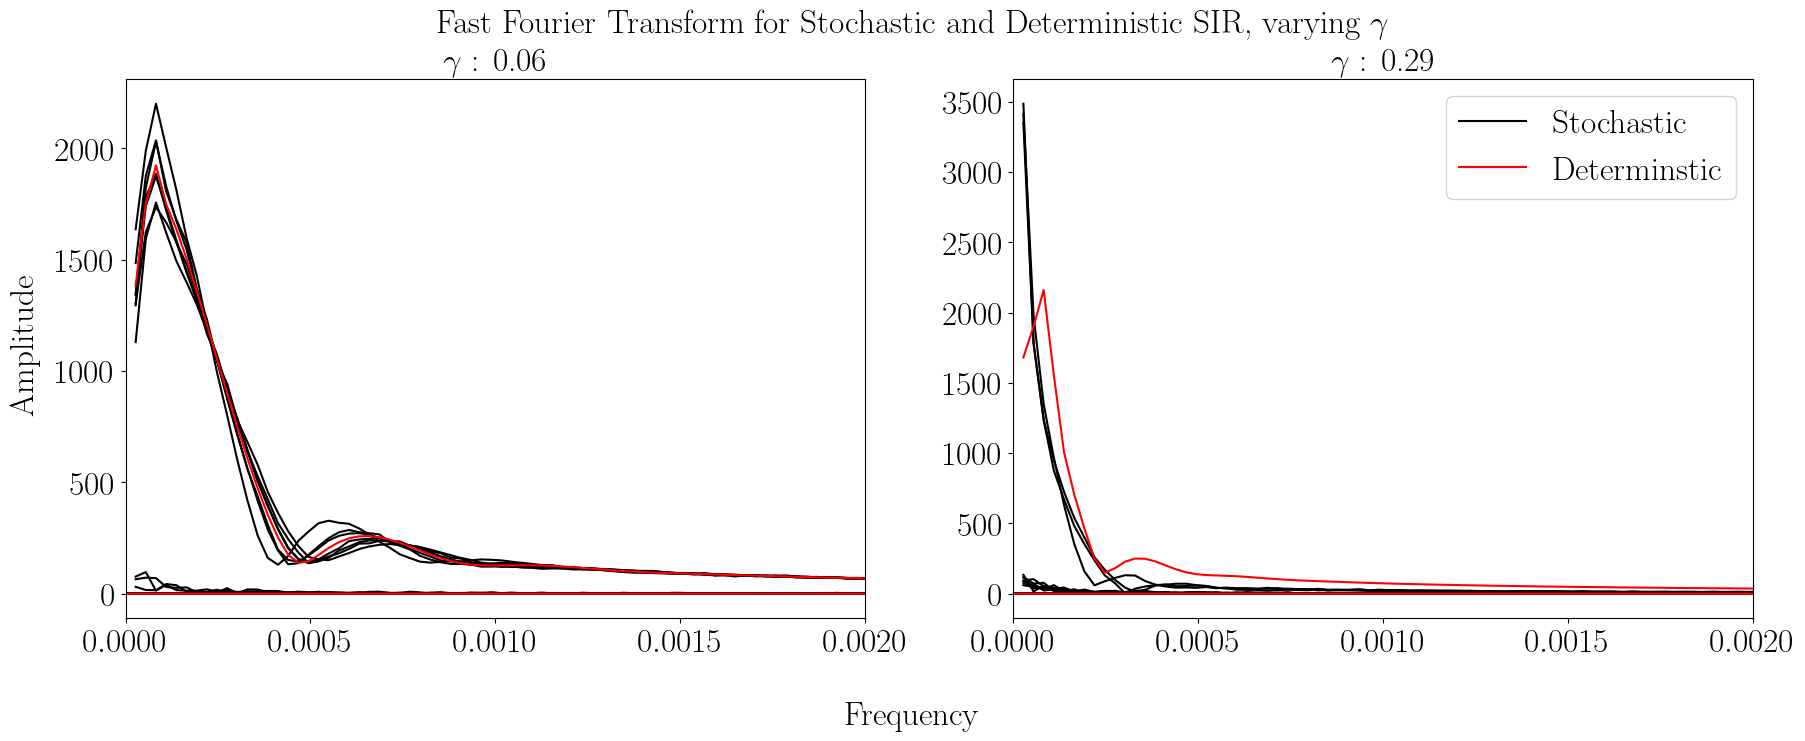

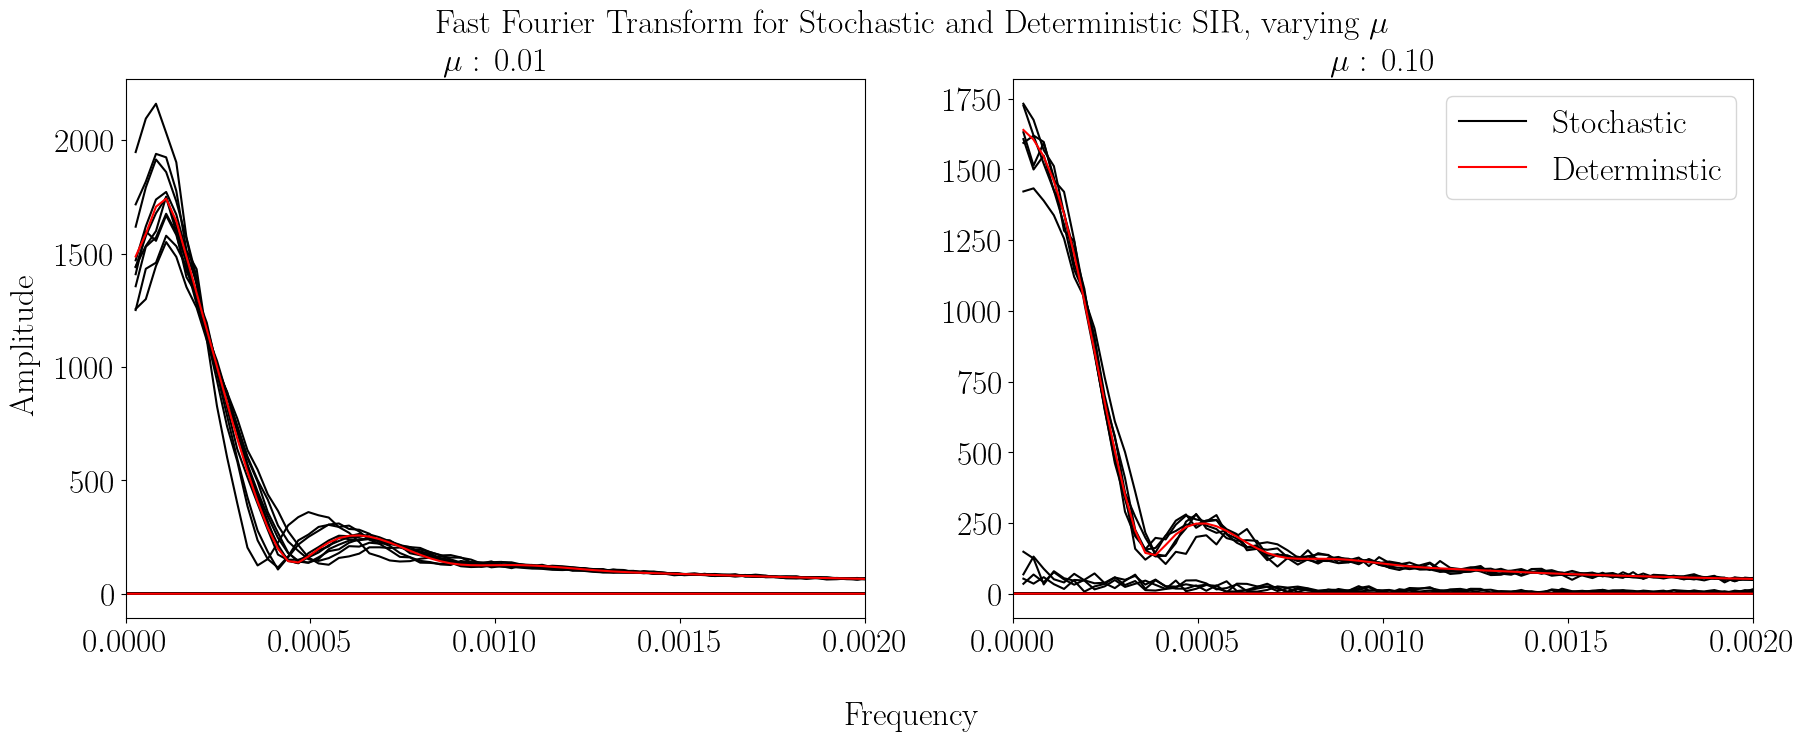

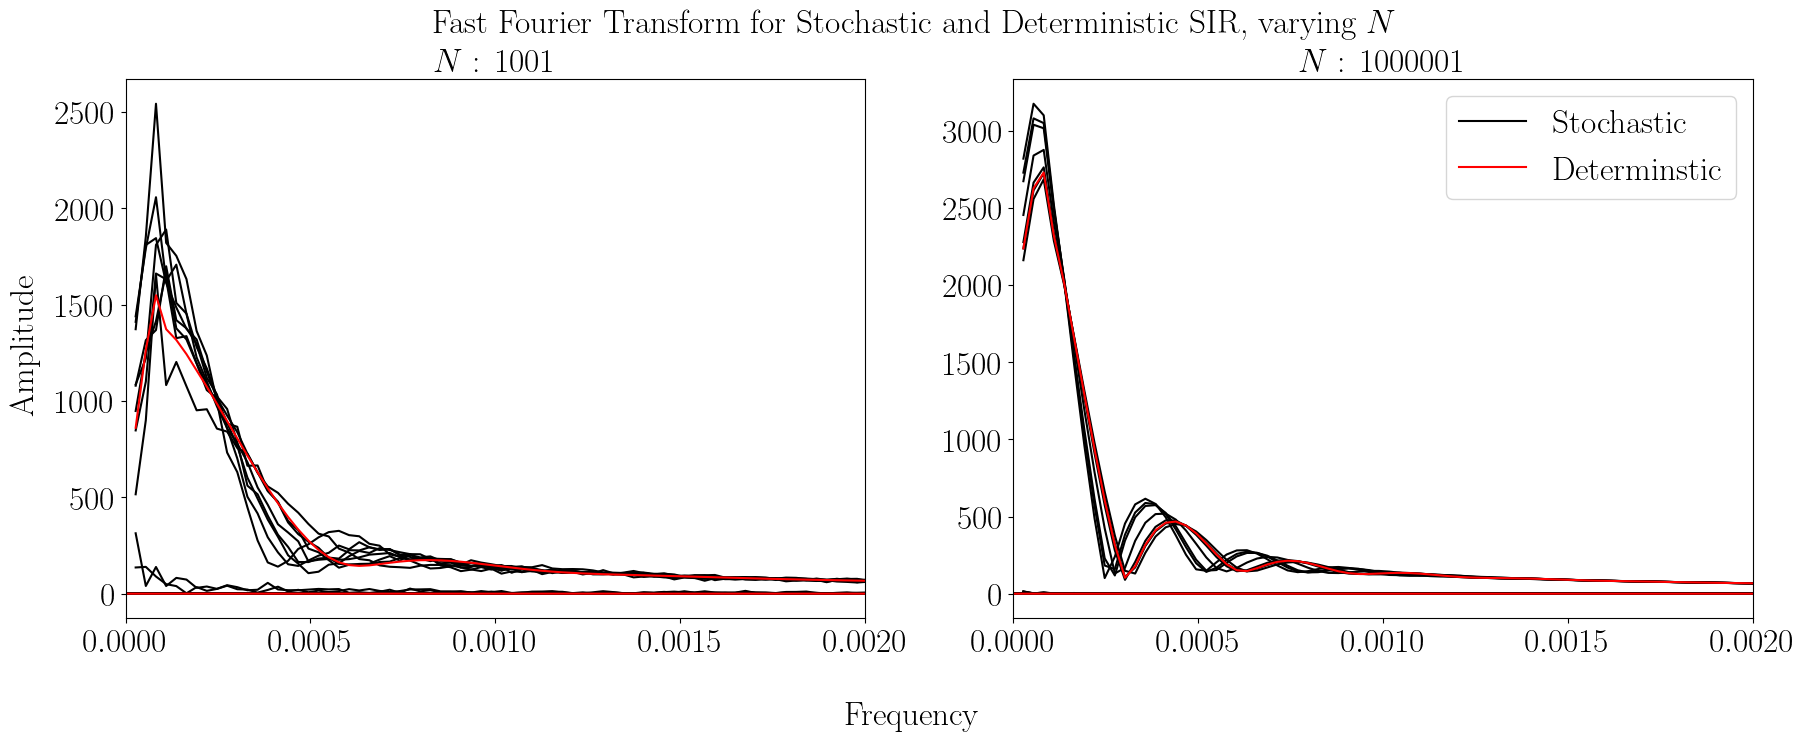

In [42]:
#Fast Fourier Transform Calculations

plt.rc('axes', titlesize=24)    
plt.rc('axes', labelsize=24)    
plt.rc('xtick', labelsize=24)   
plt.rc('ytick', labelsize=24)    
plt.rc('legend', fontsize=24)

def get_fft(data):
    data -= np.mean(data)
    fft_result = fft(data)
    frequencies = fftfreq(len(data))
    
    non_zero = np.where(frequencies != 0.0)
    frequencies = frequencies[non_zero]
    fft_result = fft_result[non_zero]
    magnitudes = np.abs(fft_result)
    return frequencies, magnitudes
    
def plotFFT(df, param):
    values = df[param].unique()
    values.sort()
    idx = np.linspace(0, len(values)-1, 2).astype(int)

    kwargs = {}
    parameters = ["beta","gamma","mu","N"]
    parameters.remove(param)
    for x in parameters:
        kwargs[x] = df[x].unique()[0]
    
    intervals = [float(x) for x in df.columns[1:-6]]
    for plot,i in enumerate(values[idx], start = 0):
        mult = i ** (param == "N") #If we are currently plotting for change in N, we need to multiply by N because the data was normalized to 1
        kwargs[param] = i 
        for x in range(10):
            stochastic_data = df.loc[(df[param] == i) & (df["group"] == "S")].iloc[x][:36400]
            stochastic_data.ffill(inplace=True)
            stochastic_data.bfill(inplace=True) #For some reason first data point sometimes is a NaN
            stochastic_data = stochastic_data.to_numpy() 
            stochastic_data *= mult 
            stochastic_freqs, stochastic_mags = get_fft(stochastic_data)
            stochastic_mags /= kwargs["N"]
            
            if x == 0: 
                axs[plot].plot(stochastic_freqs, stochastic_mags, color = "black", label = "Stochastic")
            else:
                axs[plot].plot(stochastic_freqs, stochastic_mags, color = "black")
                
        determinist_data = return_Solved(**kwargs, steps = len(intervals))[:36400, 0] * kwargs["N"]
        determinist_freqs, determinist_mags = get_fft(determinist_data)
        determinist_mags /= kwargs["N"]
        axs[plot].plot(determinist_freqs, determinist_mags, color = "r", label = "Determinstic")
        if param == "N":
            axs[plot].set_title(f"${param}$  : {int(i)}")
        else:
            axs[plot].set_title(f"$\{param}$  : {i:.2f}")
        axs[plot].set_xlim((0,.002))


fig, axs = plt.subplots(1, 2, figsize=(21, 7))
axs = axs.ravel()
plotFFT(beta_df.loc[(0.1 < beta_df["beta"]) & (beta_df["beta"] < 0.85)], "beta")
fig.suptitle("Fast Fourier Transform for Stochastic and Deterministic SIR, varying $\\beta$", fontsize = 24)
fig.text(0.5, -0.03, "Frequency", ha='center', va='center', fontsize = 24)
fig.text(0.07, 0.5, 'Amplitude', va='center', rotation='vertical', fontsize = 24)
axs[1].legend(loc="best")


fig, axs = plt.subplots(1, 2, figsize=(21, 7))
axs = axs.ravel()
plotFFT(gamma_df.loc[(0.05 < gamma_df["gamma"]) & (gamma_df["gamma"] < 0.3 )], "gamma")
fig.suptitle("Fast Fourier Transform for Stochastic and Deterministic SIR, varying $\gamma$", fontsize = 24)
fig.text(0.5, -0.03, "Frequency", ha='center', va='center', fontsize = 24)
fig.text(0.07, 0.5, 'Amplitude', va='center', rotation='vertical', fontsize = 24)
axs[1].legend(loc="best")


fig, axs = plt.subplots(1, 2, figsize=(21, 7))
axs = axs.ravel()
plotFFT(mu_df, "mu")
fig.suptitle("Fast Fourier Transform for Stochastic and Deterministic SIR, varying $\mu$", fontsize = 24)
fig.text(0.5, -0.03, "Frequency", ha='center', va='center', fontsize = 24)
fig.text(0.07, 0.5, 'Amplitude', va='center', rotation='vertical', fontsize = 24)
axs[1].legend(loc="best")


fig, axs = plt.subplots(1, 2, figsize=(21, 7))
axs = axs.ravel()
plotFFT(N_df.loc[N_df["N"] > 999], "N")
fig.suptitle("Fast Fourier Transform for Stochastic and Deterministic SIR, varying $N$", fontsize = 24)
fig.text(0.5, -0.03, "Frequency", ha='center', va='center', fontsize = 24)
fig.text(0.07, 0.5, 'Amplitude', va='center', rotation='vertical', fontsize = 24)
axs[1].legend(loc="best")

Extinction Events and Critical Community Size

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


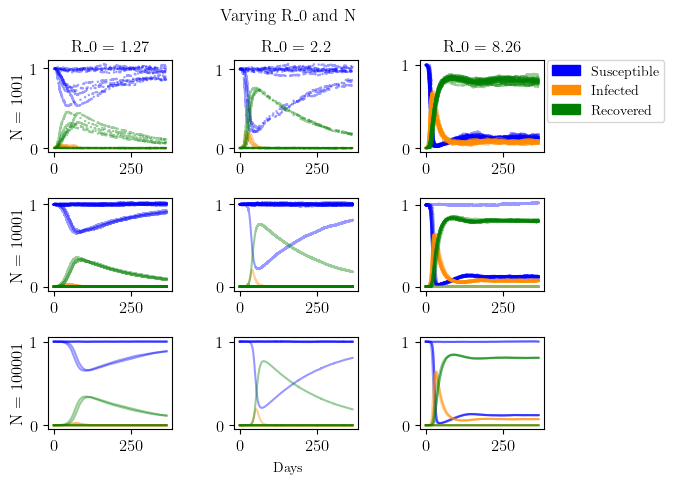

In [31]:
#Plotting SIR Behavior for Different N and R_0

plt.rc('axes', titlesize=12)    
plt.rc('axes', labelsize=12)    
plt.rc('xtick', labelsize=12)   
plt.rc('ytick', labelsize=12)    
plt.rc('legend', fontsize=12)

grouped = gamma_N_df.groupby(["group"])
grouped_R = gamma_N_df.groupby(["group", "N", "gamma"])
grouped_R_mean = gamma_N_df.groupby(["group", "N", "gamma"]).mean(numeric_only=True)


# Extract column numbers for plotting
numbers = [float(x) for x in gamma_N_df.columns[1:-7:4]]

#Setting the figure
fig, axs = plt.subplots(3, 3)

# Plotting the data
paramVals_N = gamma_N_df["N"].unique()[:-1]
paramVals_gamma = gamma_N_df["gamma"].unique()[1::3]
paramVals_gamma = paramVals_gamma[::-1]
#paramVals_gamma = paramVals_gamma[1:]

#grouped_gamma.get_group(("I", paramVal)).T[1:-7:4]

for i in range(3): 
    for j in range(3):
        axs[i,j].plot(numbers, grouped_R.get_group(("S", paramVals_N[i], paramVals_gamma[j])).T[1:-7:4], color = "blue", alpha = 0.4)
        axs[i,j].plot(numbers, grouped_R.get_group(("I", paramVals_N[i], paramVals_gamma[j])).T[1:-7:4], color = "darkorange", alpha = 0.4)
        axs[i,j].plot(numbers, grouped_R.get_group(("R", paramVals_N[i], paramVals_gamma[j])).T[1:-7:4], color = "green", alpha = 0.4)    
        axs[i,0].set_ylabel(f"N = {round(paramVals_N[i], 2)}")
        
    
    rKnot = round(0.5/(paramVals_gamma[i] + 0.005), 2)
    axs[0,i].set_title(f"R_0 = {rKnot}", fontsize = 12)

legend_handles = [mpatches.Patch(color=color) for color in color_list]
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 4.09))
fig.text(0.5, 0.03, "Days", ha='center', va='center', fontsize = 10)
fig.text(0.5, 0.97, "Varying R_0 and N", ha='center', va='center', rotation='horizontal', fontsize = 12)
legend_labels = ["Susceptible", "Infected", "Recovered"]
plt.legend(handles = legend_handles, labels = legend_labels, bbox_to_anchor=(1.02, 4.0), loc='upper left', borderaxespad=0, fontsize = 10)
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

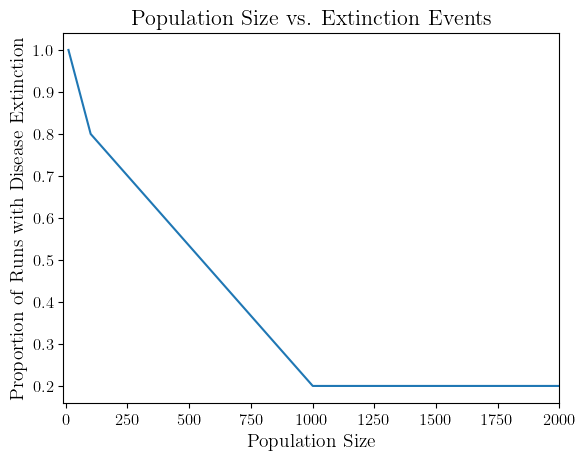

In [32]:
#Plotting Extinction Events vs. Population Size 

params_N = N_df["N"].unique()[:-1]
grouped_N = N_df.groupby(["group", "N"])

extincts = []
for param_N in params_N:
    infected_vals = grouped_N.get_group(("I", param_N)).T[1:-7]
    num_ext = sum(np.any(infected_vals == 0, axis=0))
    extincts.append(num_ext / 10)

plt.plot(params_N, extincts)
plt.xlabel('Population Size', fontsize=14)
plt.ylabel('Proportion of Runs with Disease Extinction', fontsize=14)
plt.xlim([-10, 2000])
plt.title("Population Size vs. Extinction Events", fontsize=16)
plt.show()

Question 2. SIR Models on Networks

In [1]:
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.utils import multi_runs
import ndlib.models.CompositeModel as gc
import ndlib.models.compartments as cpm

#Creating a Simulation class to ease with plotting and adjusting parameters.
class Simulation():
    def __init__(self, graph, iterations, tests, testIter, accuracy, vaccines, infected, beta, gamma, vaccination_strat, testing_strat):
        """Init the simulation with a graph, the total number of available tests, the number of vaccines for each iteration, the number of infected individuals at the start and the vaccination strategy"""
        self.graph = graph
        self.iterations = iterations
        self.tests = tests
        self.testIter = testIter
        self.accuracy = accuracy
        self.vaccines = vaccines
        self.infected = infected
        self.beta = beta
        self.gamma = gamma
        self.Nnodes= len(self.graph.nodes())
        self.testing = testing_strat
        self.prep_vaccine = vaccination_strat

        self.id= {n: {"id": id} for id,n in enumerate(self.graph.nodes())}
        self.checked = {n: {"check": "Susceptible"} for i,n in enumerate(self.graph.nodes())}
        nx.set_node_attributes(self.graph, self.id)
        nx.set_node_attributes(self.graph, self.checked)

        self.current_iteration = 0
        self.vaccine_targets = []
        self.history= []
        self.iterationBunch = []
        self.model = None
        self.trends = None
        self.testing_target = None
        self.vaccine_target= None
        
    def setup_model(self):
        self.trends =  None
        self.model = gc.CompositeModel(self.graph)

        self.model.add_status("Susceptible")
        self.model.add_status("Infected")
        self.model.add_status("Recovered")
        config = mc.Configuration()
        infections = np.random.randint(self.Nnodes, size=self.infected)
        config.add_model_initial_configuration("Infected", infections)

        # c1 and c2 are the rules for spread and recovered, the trigger status means that it is based on the number of neighbors
        c1 = cpm.NodeStochastic(self.beta, triggering_status="Infected")
        c2 = cpm.NodeStochastic(self.gamma)
        self.model.add_rule("Susceptible", "Infected", c1)
        self.model.add_rule("Infected", "Recovered", c2)

        self.model.set_initial_status(config)

    def vaccination(self):
        for node in self.graph.nodes():
            if node in self.vaccine_targets and self.model.status[node] == 0:
                self.model.status[node] = 2
        [self.history.append(x) for x in self.vaccine_targets]
        self.vaccine_targets = []
        

    def run(self, N):
            S = np.ndarray((N,self.iterations))
            I = np.ndarray((N,self.iterations))
            R = np.ndarray((N,self.iterations))
            for _ in range(N):
                for i in range(self.iterations):
                    if self.tests:
                        self.testing(self, self.accuracy)
                    self.prep_vaccine(self)
                    self.vaccination()
                    self.iterationBunch.append(self.model.iteration())
                data = self.model.build_trends(self.iterationBunch)[0]['trends']['node_count']
                self.history = []
                S[_,:] =  data[0][-self.iterations:]
                I[_,:] =  data[1][-self.iterations:]
                R[_,:] =  data[2][-self.iterations:]
                self.setup_model()
                self.model.reset()
            return [S,I,R]

def baseline(args, test=False):
    pass

def plot_data(data, ax, percentile=90, title=False, individual=True):
    S,I,R = data[0],data[1],data[2]
    meanS = np.mean(S,axis=0)
    meanI = np.mean(I,axis=0)
    meanR = np.mean(R,axis=0)

    varS = np.std(S,axis=0)
    varI = np.std(I,axis=0)
    varR = np.std(R,axis=0)

    x_axis = range(len(meanS))
    if title:
        ax.set_title(title)
    for mean,var in [(meanS,varS),(meanI,varI),(meanR,varR)]:
        ax.plot(x_axis, mean)
        ax.fill_between(x_axis, mean + 0.45*var, mean- 0.45*var, alpha= 0.5)
    if individual:
        for i in range(S.shape[0]):
            ax.plot(x_axis, S[i], color = "b")
            ax.plot(x_axis, I[i], color = "orange")
            ax.plot(x_axis, R[i], color = "g")
    print(max(meanI))
    ax.axhline(max(meanI), color="gray", alpha=.3)
    return ax

def stackedplot_data(data, ax, percentile=90, label=None, individual=True, color=0):
    colors = ["#93B7BE", "#E0CA3C", "#A799B7","#048A81"]
    I = data[1]
    mean = np.mean(I,axis=0)

    var = np.std(I,axis=0)

    x_axis = range(len(mean))
    ax.plot(x_axis, mean,color=colors[color], label = label)
    ax.fill_between(x_axis, mean + 0.45*var, mean- 0.45*var, alpha= 0.5, color=colors[color])
    # for i in range(0,I.shape[0],5):
    #     ax.plot(x_axis, I[i], alpha=.3,color=colors[color])
    print(max(mean))
    ax.axhline(max(mean), color="gray", alpha=.3)
    return ax

Varying Network Structure

[Text(0, 0.5, '$\\langle k \\rangle = 5$')]

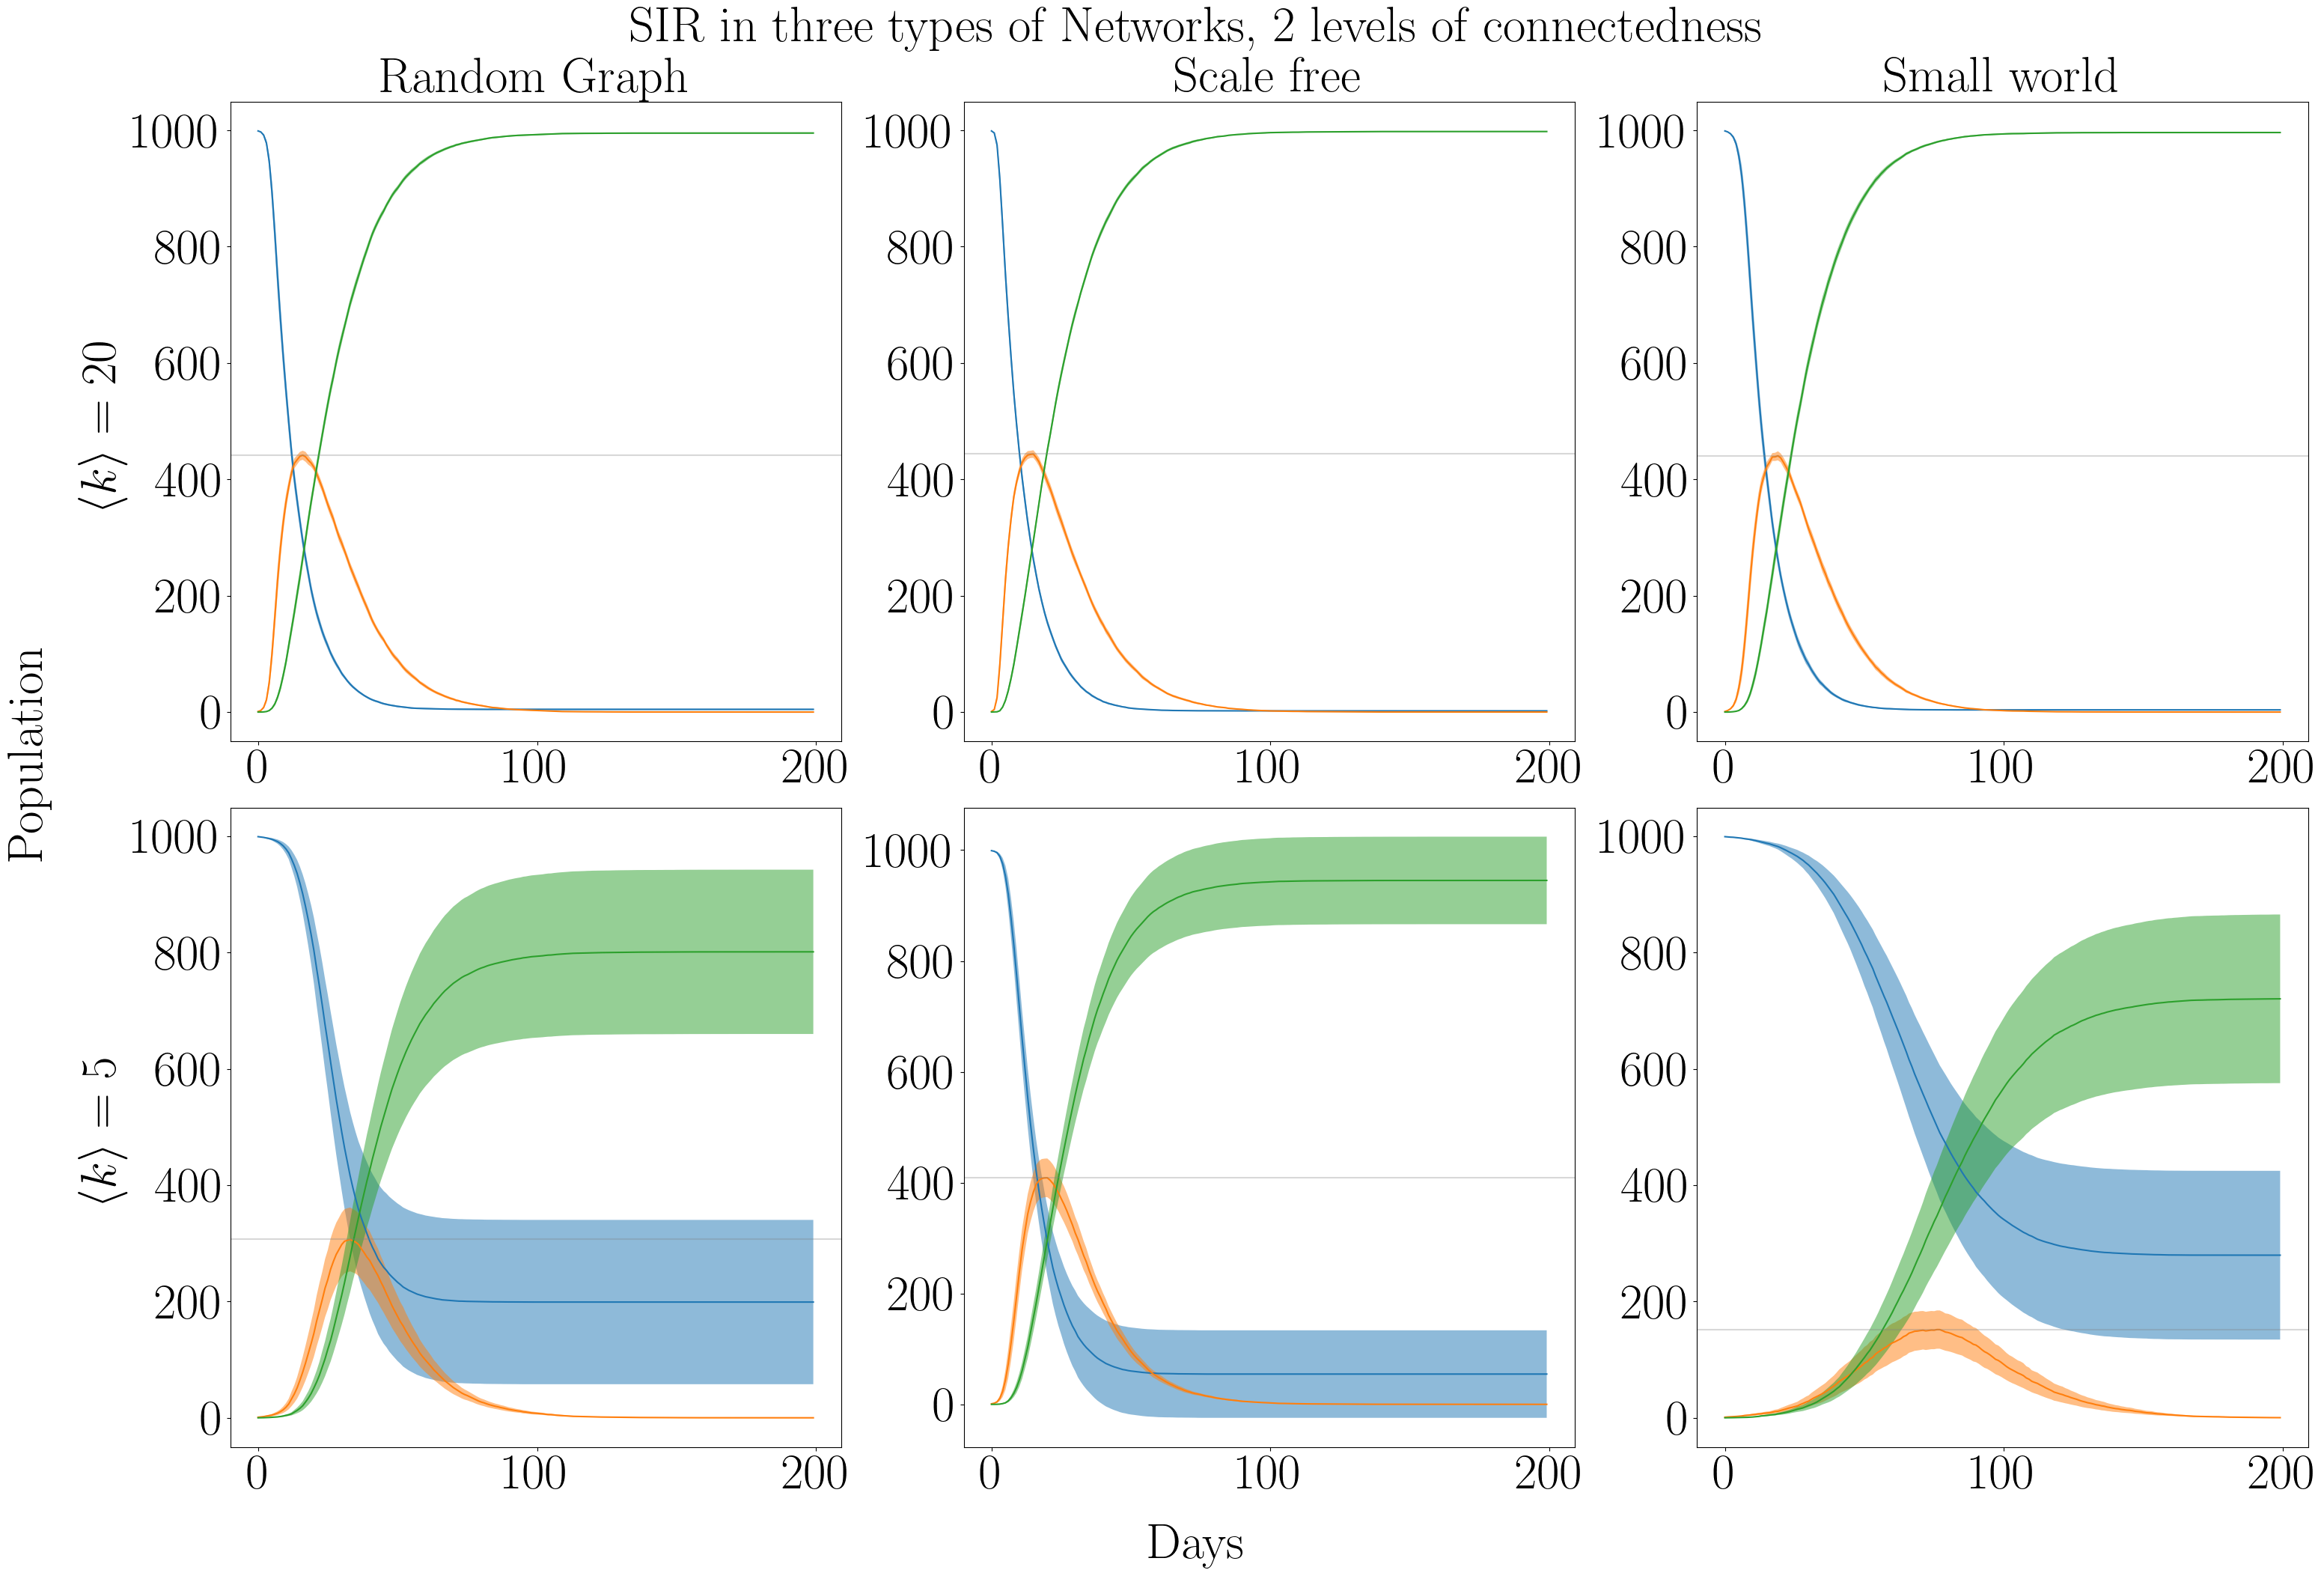

In [37]:
#Varying Network Structure and Connectedness

plt.rc('axes', titlesize=48)    
plt.rc('axes', labelsize=48)    
plt.rc('xtick', labelsize=48)   
plt.rc('ytick', labelsize=48)    
plt.rc('legend', fontsize=48)

graphER = nx.erdos_renyi_graph(1000, 0.02)
graphER2 = nx.erdos_renyi_graph(1000, 0.005)
graphBA = nx.barabasi_albert_graph(1000, 20)
graphBA2 = nx.barabasi_albert_graph(1000, 5)
graphWS = nx.watts_strogatz_graph(1000,20,0.2)
graphWS2 = nx.watts_strogatz_graph(1000,5,0.2)

graphs = [graphER,  graphBA,  graphWS,graphER2, graphBA2,graphWS2]

plotnames = [  "Random Graph",
               "Scale free",
               "Small world",
]
kwargs = {
    "graph": None,
    "iterations": 200,
    "tests": 200,
    "testIter":10,
    "accuracy": 1,
    "vaccines": 5,
    "infected": 1,
    "beta": 1/10 ,
    "gamma": 1/14,
    "vaccination_strat": baseline,
    "testing_strat": baseline,
}
runs = 30
fig,ax = plt.subplots(2,3, figsize=(30,20), layout="constrained")

for plot,graph in enumerate(graphs):
    kwargs["graph"] = graph
    sim = Simulation(**kwargs)
    sim.setup_model()
    base_data = sim.run(runs)
    if plot < 3:
        title = plotnames[plot]
    else:
        title = False
    plot_data(base_data, ax.flat[plot], 90, title, individual=False)
fig.suptitle("SIR in three types of Networks, 2 levels of connectedness", fontsize = 48)
fig.text(0.5, -0.03, "Days", ha='center', va='center', fontsize = 48)
fig.text(-0.03, 0.5, 'Population', va='center', rotation='vertical', fontsize = 48)
plt.setp(ax[0,0], ylabel='$\langle k \\rangle = 20$')
plt.setp(ax[1,0], ylabel='$\langle k \\rangle = 5$')

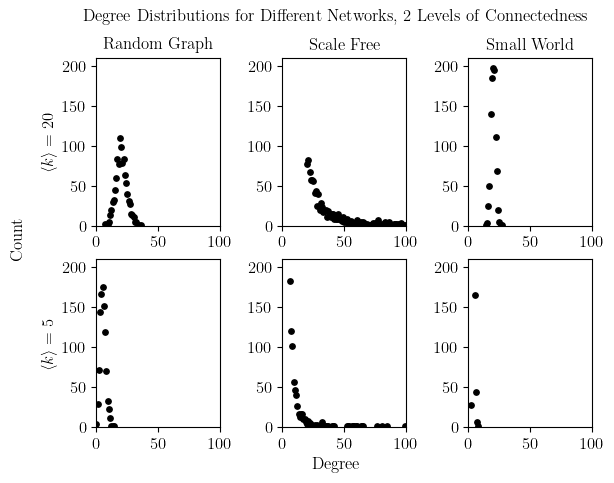

In [76]:
#np.random.seed(123)

fig, axs = plt.subplots(2, 3)
plt.rc('axes', titlesize=12)    
plt.rc('axes', labelsize=12)    
plt.rc('xtick', labelsize=12)   
plt.rc('ytick', labelsize=12)    
plt.rc('legend', fontsize=12)


degrees = {}
for node,degree in graphs[0].degree:
    if degree in degrees.keys():
       degrees[degree] += 1 
    else:
        degrees[degree] = 1
        
axs[0,0].scatter(degrees.keys(),degrees.values(), color="black", s = 15)

degrees = {}
for node,degree in graphs[1].degree:
    if degree in degrees.keys():
       degrees[degree] += 1 
    else:
        degrees[degree] = 1
        
axs[0,1].scatter(degrees.keys(),degrees.values(), color="black", s = 15)

degrees = {}
for node,degree in graphs[2].degree:
    if degree in degrees.keys():
       degrees[degree] += 1 
    else:
        degrees[degree] = 1
        
axs[0,2].scatter(degrees.keys(),degrees.values(), color="black", s = 15)

degrees = {}
for node,degree in graphs[3].degree:
    if degree in degrees.keys():
       degrees[degree] += 1 
    else:
        degrees[degree] = 1
        
axs[1,0].scatter(degrees.keys(),degrees.values(), color="black", s = 15)

degrees = {}
for node,degree in graphs[4].degree:
    if degree in degrees.keys():
       degrees[degree] += 1 
    else:
        degrees[degree] = 1
        
axs[1,1].scatter(degrees.keys(),degrees.values(), color="black", s = 15)

degrees = {}
for node,degree in graphs[5].degree:
    if degree in degrees.keys():
       degrees[degree] += 1 
    else:
        degrees[degree] = 1
        
axs[1,2].scatter(degrees.keys(),degrees.values(), color="black", s = 15)


# plt.title("Degree Distribution of Transmission Network", fontsize = 18)
# plt.xlabel("Degree", fontsize = 18)
# plt.ylabel("Count", fontsize = 18)
plotnames = [  "Random Graph",
               "Scale Free",
               "Small World",]

fig.suptitle("Degree Distributions for Different Networks, 2 Levels of Connectedness", fontsize = 12)
fig.text(0.5, 0.03, "Degree", ha='center', va='center', fontsize = 12)
fig.text(-0.01, 0.5, 'Count', va='center', rotation='vertical', fontsize = 12)
plt.subplots_adjust(wspace = 0.5, hspace = 0.2)
plt.setp(axs[0,0], ylabel='$\langle k \\rangle = 20$')
plt.setp(axs[1,0], ylabel='$\langle k \\rangle = 5$')
for i in range(3):
    plt.setp(axs[0,i], ylim=[0,210], xlim=[0,100], title = plotnames[i])
    plt.setp(axs[1,i], ylim=[0,210], xlim=[0,100])
    
    


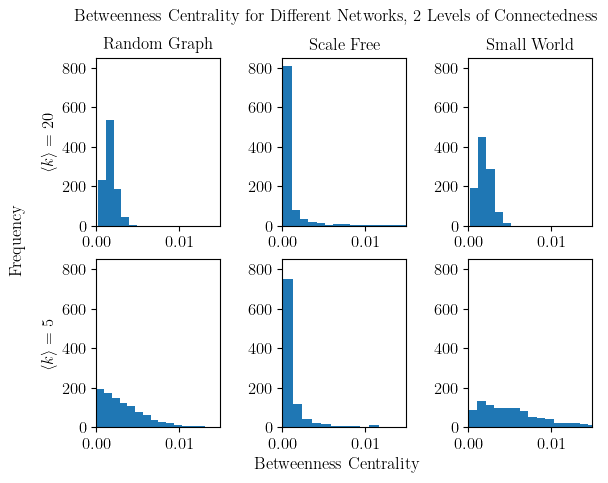

In [77]:
#Betweenness Centrality Analysis for Different Graphs

fig, axs = plt.subplots(2, 3)
plt.rc('axes', titlesize=12)    
plt.rc('axes', labelsize=12)    
plt.rc('xtick', labelsize=12)   
plt.rc('ytick', labelsize=12)    
plt.rc('legend', fontsize=12)

bet_GER = nx.betweenness_centrality(graphER, normalized = True)
bet_GBA = nx.betweenness_centrality(graphBA, normalized = True) 
bet_GWS = nx.betweenness_centrality(graphWS, normalized = True)   
bet_GER2 = nx.betweenness_centrality(graphER2, normalized = True)
bet_GBA2 = nx.betweenness_centrality(graphBA2, normalized = True) 
bet_GWS2 = nx.betweenness_centrality(graphWS2, normalized = True)    
        
axs[0,0].hist(bet_GER.values(), bins = 5)        
axs[0,1].hist(bet_GBA.values(), bins = 30)
axs[0,2].hist(bet_GWS.values(), bins = 5)
axs[1,0].hist(bet_GER2.values(), bins = 20)
axs[1,1].hist(bet_GBA2.values(), bins = 70)
axs[1,2].hist(bet_GWS2.values(), bins = 30)

plotnames = [  "Random Graph",
               "Scale Free",
               "Small World",]

fig.suptitle("Betweenness Centrality for Different Networks, 2 Levels of Connectedness", fontsize = 12)
fig.text(0.5, 0.03, "Betweenness Centrality", ha='center', va='center', fontsize = 12)
fig.text(-0.01, 0.5, 'Frequency', va='center', rotation='vertical', fontsize = 12)
plt.subplots_adjust(wspace = 0.5, hspace = 0.2)
plt.setp(axs[0,0], ylabel='$\langle k \\rangle = 20$')
plt.setp(axs[1,0], ylabel='$\langle k \\rangle = 5$')
for i in range(3):
    plt.setp(axs[0,i], ylim=[0,850], xlim=[0,0.015], title = plotnames[i])
    plt.setp(axs[1,i], ylim=[0,850], xlim=[0,0.015])

Varying SIR Parameters on Different Networks

<Axes: title={'center': 'R_0 = 5'}>

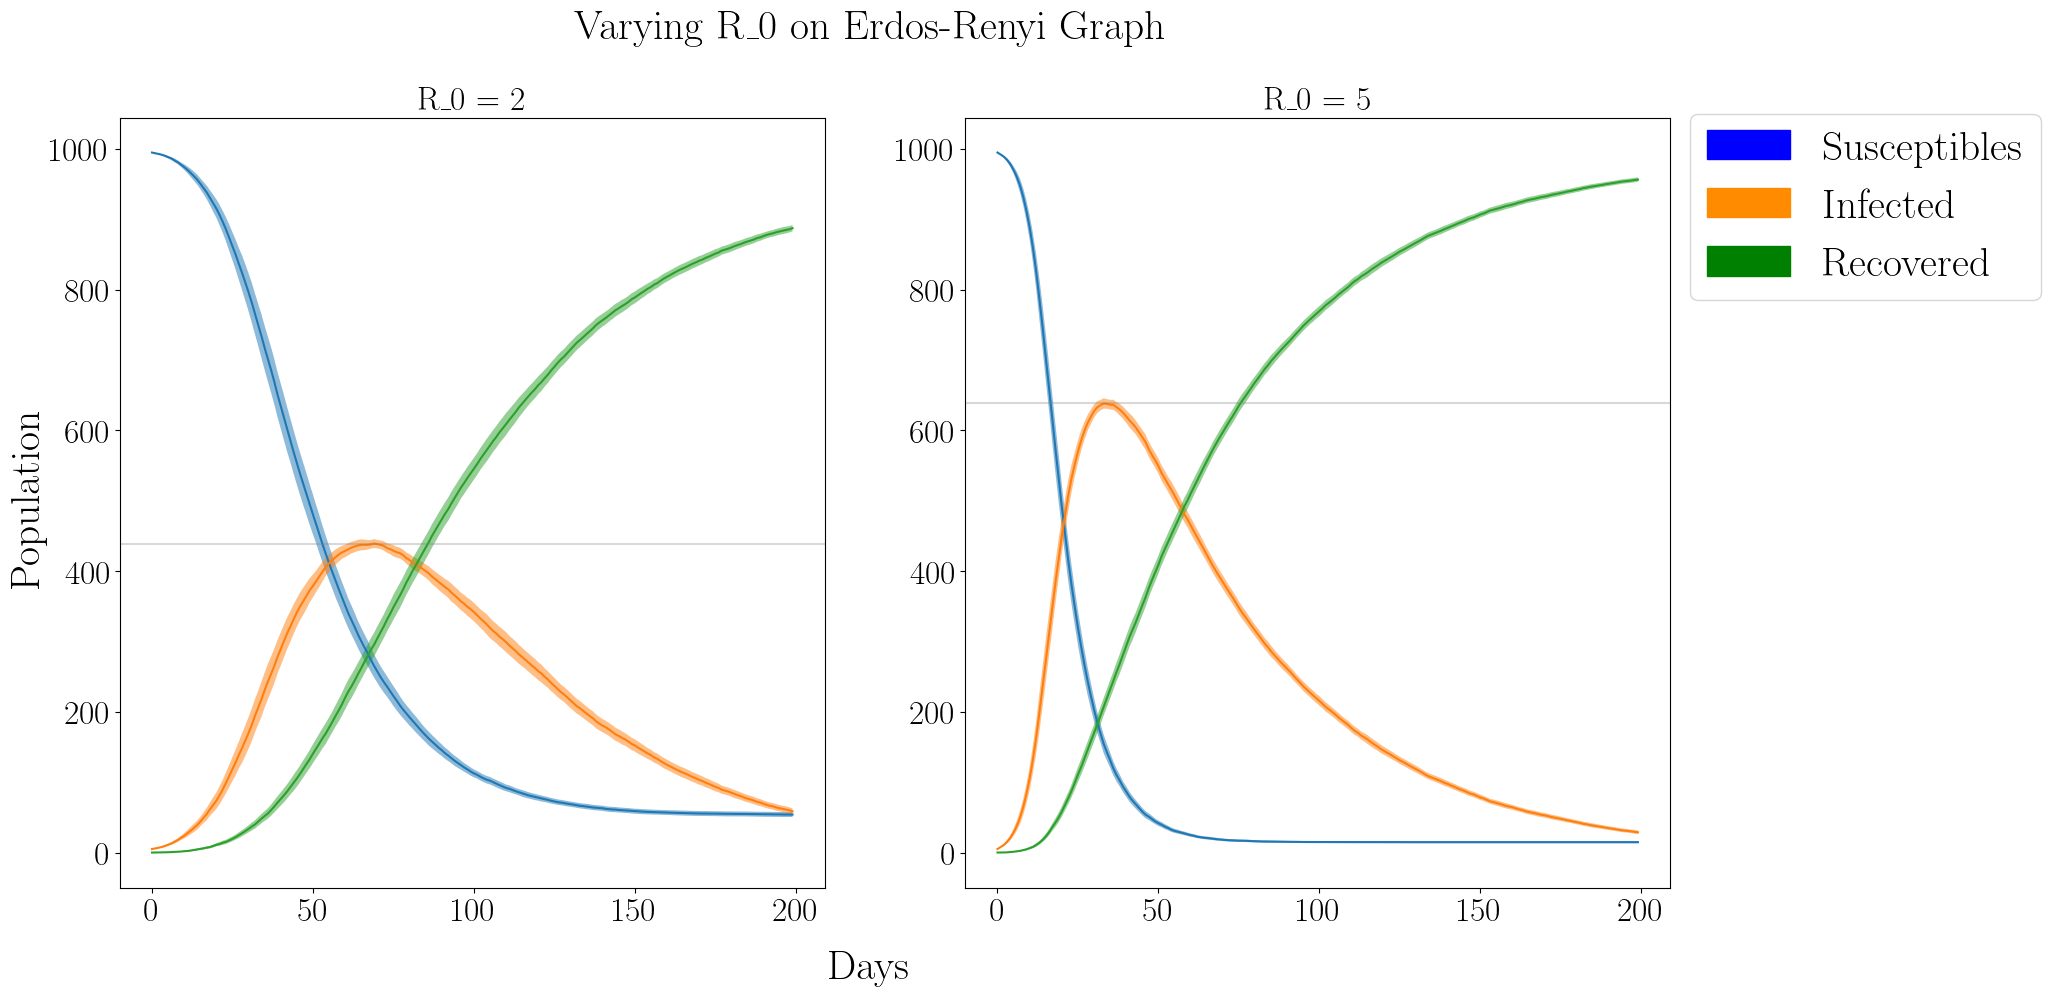

In [48]:
#Varying R_0 on ER Graphs

np.random.seed(123)

plt.rc('axes', titlesize=24)    
plt.rc('axes', labelsize=24)    
plt.rc('xtick', labelsize=24)   
plt.rc('ytick', labelsize=24)    

kwargs = {
    "graph": graphER2,
    "iterations": 200,
    "tests": 100,
    "testIter":10,
    "accuracy": 1,
    "vaccines": 5,
    "infected": 5,
    "beta": 1/25,
    "gamma": 1/50,
    "vaccination_strat": baseline,
    "testing_strat": baseline,  
}

runs = 30
fig,ax = plt.subplots(1,2, figsize=(20,10))
ax.ravel()
sim = Simulation(**kwargs)
sim.setup_model()
data1 = sim.run(runs)
plot_data(data1, ax[0], 90, "R_0 = 2", individual = False)

legend_handles = [mpatches.Patch(color=color) for color in color_list]
fig.text(0.5, 0.03, "Days", ha='center', va='center', fontsize = 30)
fig.text(0.07, 0.5, 'Population', va='center', rotation='vertical', fontsize = 30)
fig.text(0.5, 0.97, "Varying R_0 on Erdos-Renyi Graph", ha='center', va='center', rotation='horizontal', fontsize = 30)
legend_labels = ["Susceptibles", "Infected", "Recovered"]
fig.legend(handles = legend_handles, labels = legend_labels, bbox_to_anchor=(0.91, 0.884), loc='upper left', borderaxespad=0, fontsize = 30)


kwargs["beta"] = 1/10
kwargs["gamma"] = 1/50
sim = Simulation(**kwargs)
sim.setup_model()
data2 = sim.run(runs)
plot_data(data2, ax[1], 90, "R_0 = 5", individual = False)

<Axes: title={'center': 'R_0 = 5'}>

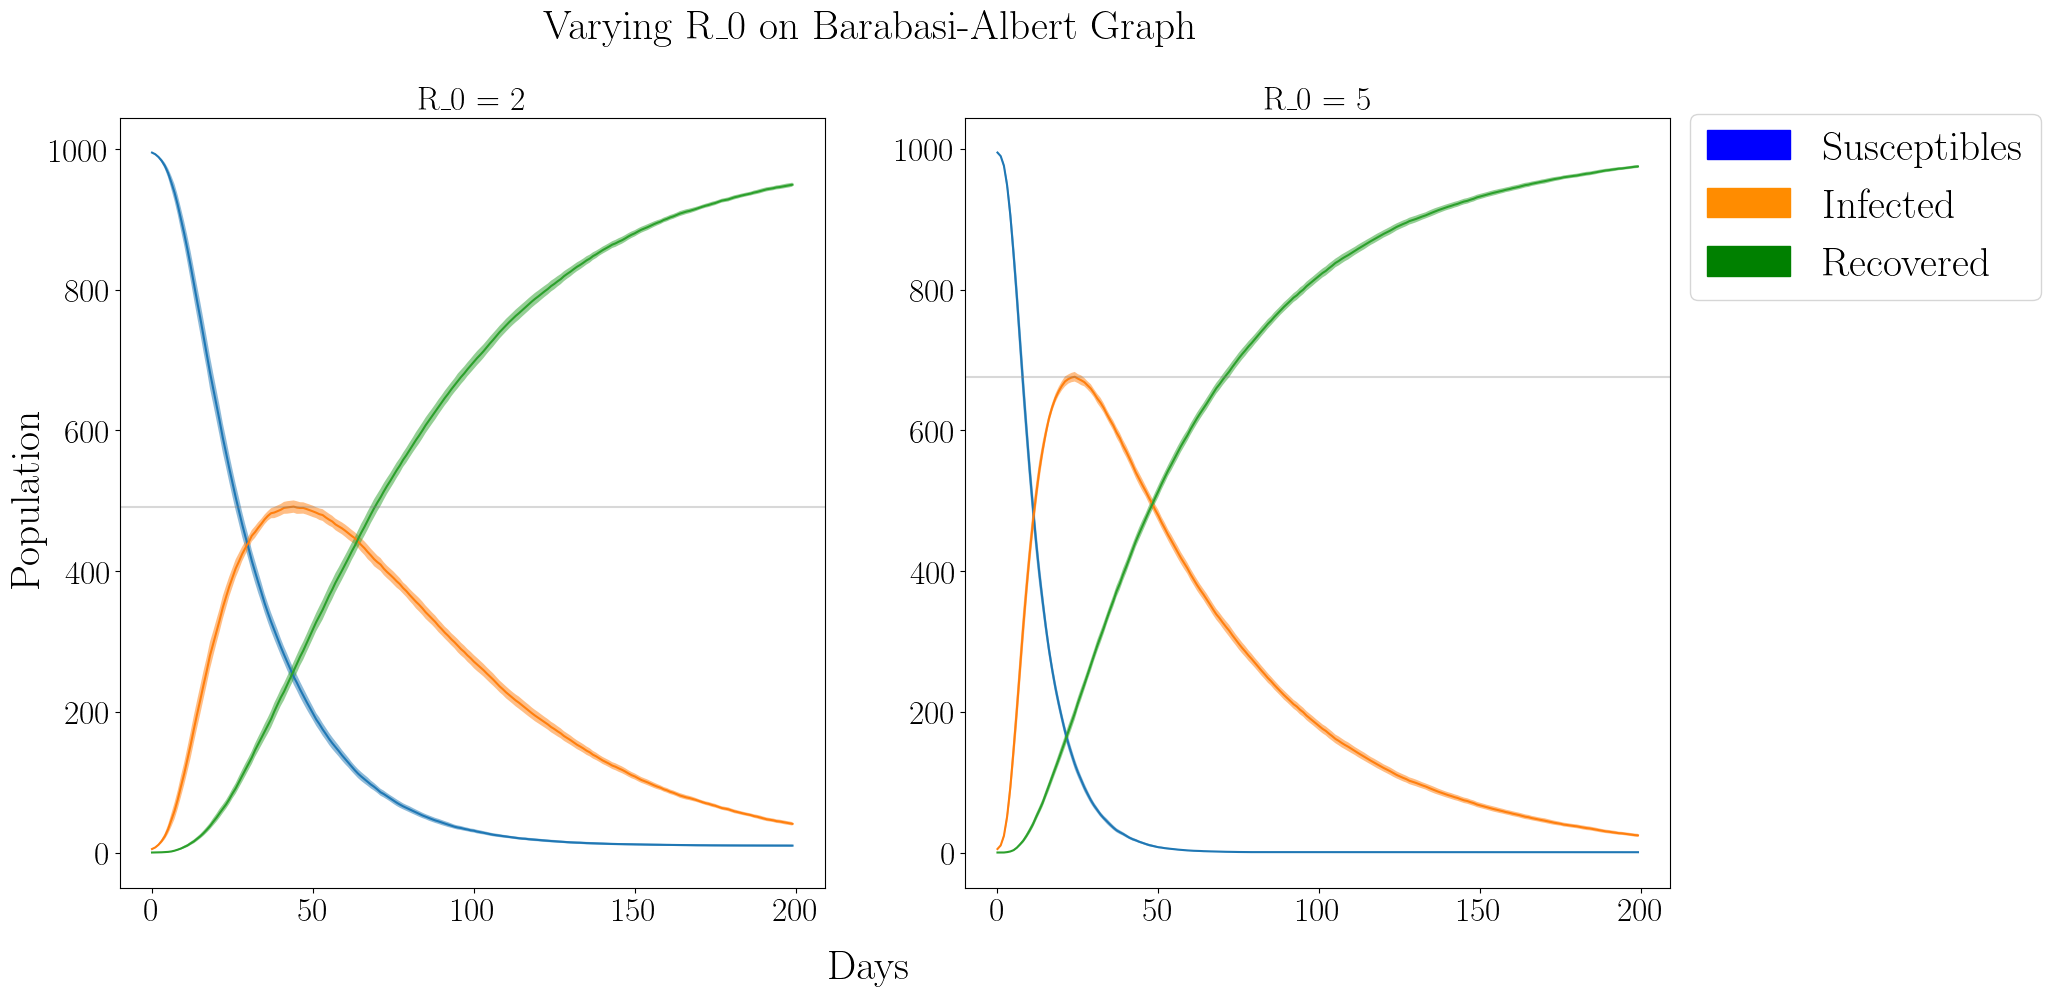

In [54]:
#Varying R_0 on ER Graphs

np.random.seed(123)

plt.rc('axes', titlesize=24)    
plt.rc('axes', labelsize=24)    
plt.rc('xtick', labelsize=24)   
plt.rc('ytick', labelsize=24)    

kwargs = {
    "graph": graphBA2,
    "iterations": 200,
    "tests": 100,
    "testIter":10,
    "accuracy": 1,
    "vaccines": 5,
    "infected": 5,
    "beta": 1/25,
    "gamma": 1/50,
    "vaccination_strat": baseline,
    "testing_strat": baseline,  
}

runs = 30
fig,ax = plt.subplots(1,2, figsize=(20,10))
ax.ravel()
sim = Simulation(**kwargs)
sim.setup_model()
data1 = sim.run(runs)
plot_data(data1, ax[0], 90, "R_0 = 2", individual = False)

legend_handles = [mpatches.Patch(color=color) for color in color_list]
fig.text(0.5, 0.03, "Days", ha='center', va='center', fontsize = 30)
fig.text(0.07, 0.5, 'Population', va='center', rotation='vertical', fontsize = 30)
fig.text(0.5, 0.97, "Varying R_0 on Barabasi-Albert Graph", ha='center', va='center', rotation='horizontal', fontsize = 30)
legend_labels = ["Susceptibles", "Infected", "Recovered"]
fig.legend(handles = legend_handles, labels = legend_labels, bbox_to_anchor=(0.91, 0.884), loc='upper left', borderaxespad=0, fontsize = 30)


kwargs["beta"] = 1/10
kwargs["gamma"] = 1/50
sim = Simulation(**kwargs)
sim.setup_model()
data2 = sim.run(runs)
plot_data(data2, ax[1], 90, "R_0 = 5", individual = False)

<Axes: title={'center': 'R_0 = 5'}>

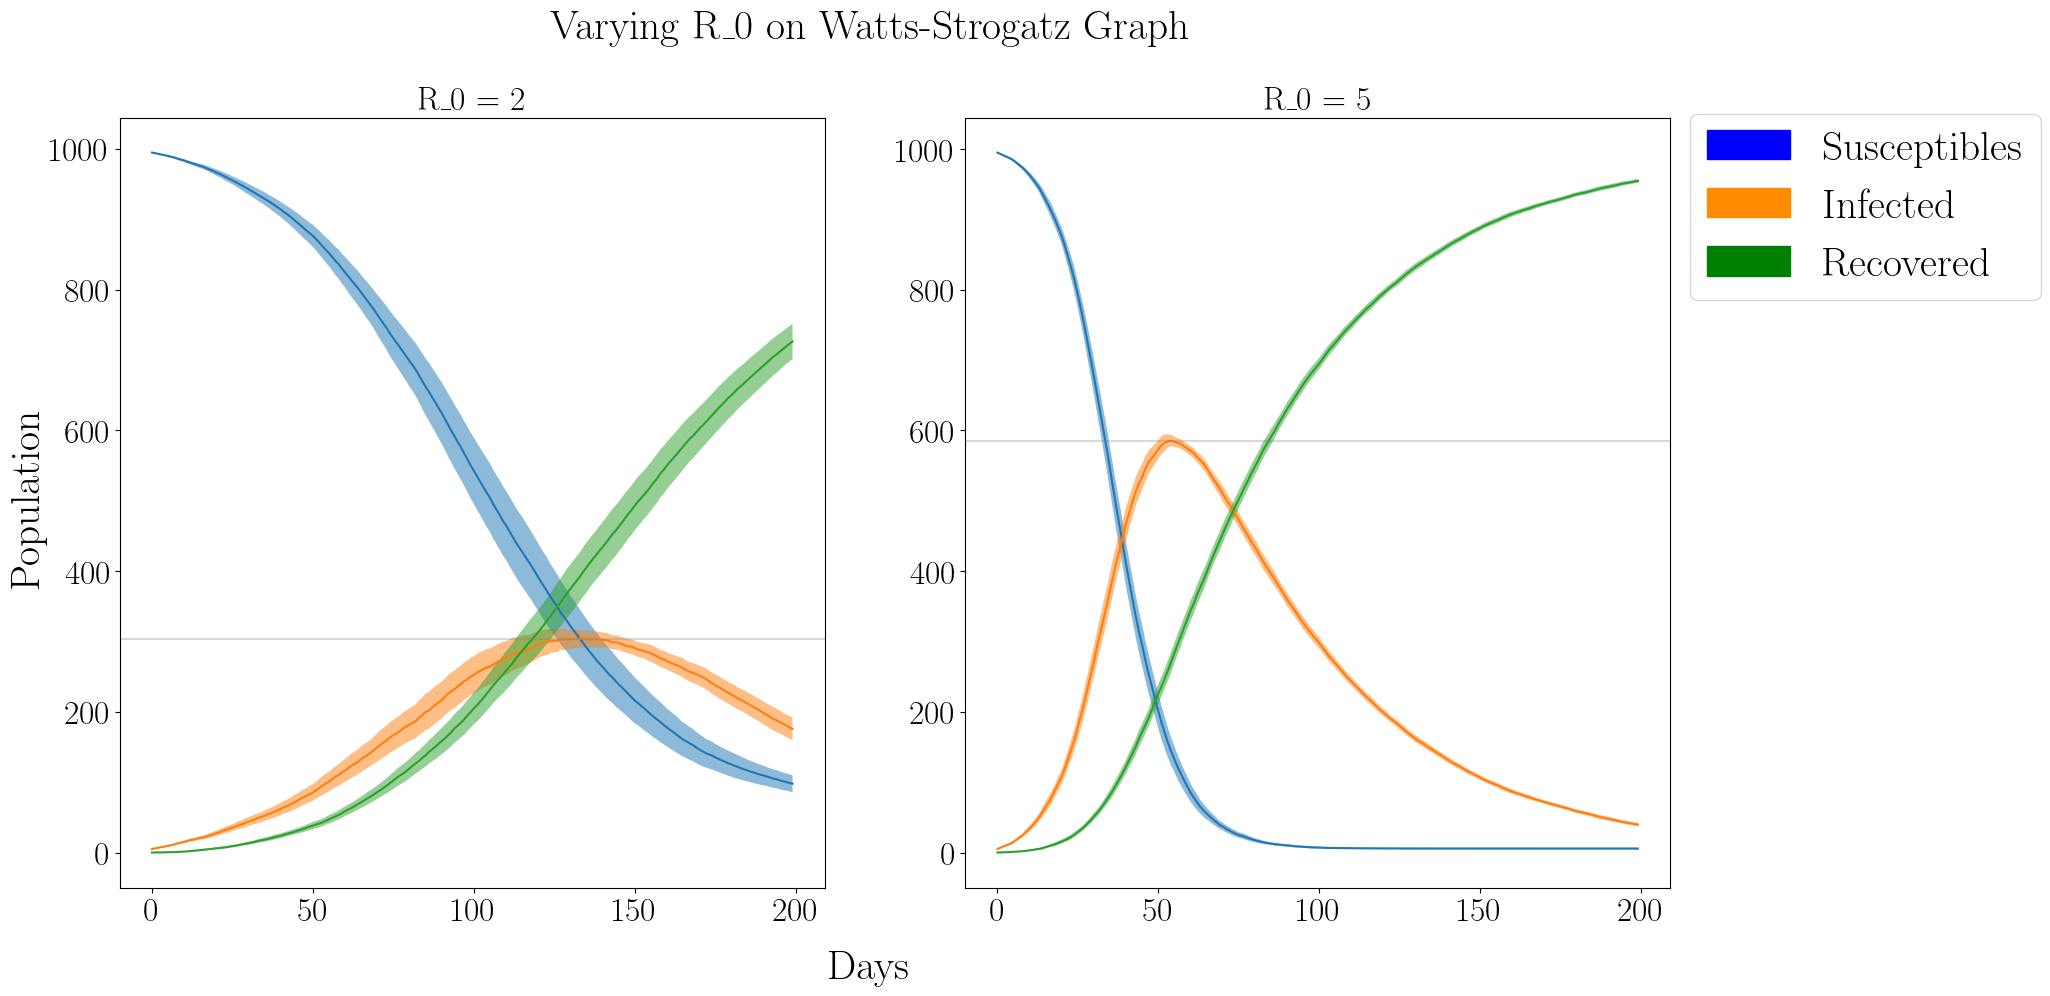

In [56]:
#Varying R_0 on ER Graphs

np.random.seed(123)

plt.rc('axes', titlesize=24)    
plt.rc('axes', labelsize=24)    
plt.rc('xtick', labelsize=24)   
plt.rc('ytick', labelsize=24)    

kwargs = {
    "graph": graphWS2,
    "iterations": 200,
    "tests": 100,
    "testIter":10,
    "accuracy": 1,
    "vaccines": 5,
    "infected": 5,
    "beta": 1/25,
    "gamma": 1/50,
    "vaccination_strat": baseline,
    "testing_strat": baseline,  
}

runs = 30
fig,ax = plt.subplots(1,2, figsize=(20,10))
ax.ravel()
sim = Simulation(**kwargs)
sim.setup_model()
data1 = sim.run(runs)
plot_data(data1, ax[0], 90, "R_0 = 2", individual = False)

legend_handles = [mpatches.Patch(color=color) for color in color_list]
fig.text(0.5, 0.03, "Days", ha='center', va='center', fontsize = 30)
fig.text(0.07, 0.5, 'Population', va='center', rotation='vertical', fontsize = 30)
fig.text(0.5, 0.97, "Varying R_0 on Watts-Strogatz Graph", ha='center', va='center', rotation='horizontal', fontsize = 30)
legend_labels = ["Susceptibles", "Infected", "Recovered"]
fig.legend(handles = legend_handles, labels = legend_labels, bbox_to_anchor=(0.91, 0.884), loc='upper left', borderaxespad=0, fontsize = 30)


kwargs["beta"] = 1/10
kwargs["gamma"] = 1/50
sim = Simulation(**kwargs)
sim.setup_model()
data2 = sim.run(runs)
plot_data(data2, ax[1], 90, "R_0 = 5", individual = False)

Vaccination Strategies on Networks

In [8]:
#Trying Different Vaccination Strategies on the Given Network
np.random.seed(123)
f = pd.read_csv("transmission_network.csv", header=0, index_col=0, delimiter=";")
# Removing the weights
for column in f.columns:
    f[column] = [1 if x else 0 for x in f[column]]
graph_part2 = nx.Graph(f.values)


def random_vaccination(simulation):
    available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible"]
    if available:
        simulation.vaccine_targets = np.random.choice(available, size=simulation.vaccines)
        
def random_testing(simulation, accuracy=1):
    testing = np.random.choice(simulation.graph.nodes(), size= simulation.testIter)
    for node in testing:
        actual_status = ["Susceptible", "Infected", "Recovered"][simulation.model.status[node]] ## Poor man's dictionary
        test_result = np.random.choice([actual_status, "Susceptible"], size=1, p=[accuracy, 1-accuracy])[0]
        simulation.graph.nodes()[node]["check"] = test_result
        simulation.tests -= 1

def centrality_testing(simulation, accuracy=1):
    available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history]

    testing = sorted(simulation.graph.degree(), key=lambda x: x[1], reverse=True)
    testing = [node for node,_ in testing if node in available]
    for node in testing[:simulation.testIter]:
        actual_status = ["Susceptible", "Infected", "Recovered"][simulation.model.status[node]] ## Poor man's dictionary
        test_result = np.random.choice([actual_status, "Susceptible"], size=1, p=[accuracy, 1-accuracy])[0]
        simulation.graph.nodes()[node]["check"] = test_result
        simulation.tests -= 1

## Centrality measures
def centrality_vaccination(simulation):
    available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history]
    
    targets = sorted(simulation.graph.degree(), key=lambda x: x[1], reverse=True)
    available_target = [node for node,_ in targets if node in available]
    simulation.vaccine_targets = available_target[:simulation.vaccines]

## Centrality measures
def closeness_vaccination(simulation):
    available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history]
    while len(simulation.vaccine_targets) > simulation.vaccines:
        initial_nodes = np.random.choice(available, size=5)
        for j in initial_nodes:
            neighbor = np.random.choice(simulation.graph.neighbors(j), size=1)
            if len(simulation.vaccine_targets) > simulation.vaccines:
                simulation.vaccine_targets.append(neighbor)
                
def neighbor_vaccination(simulation):
    infecteds = [node for node in simulation.graph.nodes if simulation.graph.nodes[node]["check"] == "Infected"]
    available = [node for node in simulation.graph.nodes if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history]
    all_neighbors = {}
    for infected in infecteds:
        for neighbor in simulation.graph.neighbors(infected):
            all_neighbors[neighbor] = len([*simulation.graph.neighbors(neighbor)])
    available_target = {node:degree for node,degree in all_neighbors.items() if node in available}
    targets = sorted(available_target.keys(), key=lambda x: available_target[x], reverse=True)
    # print(targets)
    simulation.vaccine_targets = targets[:simulation.vaccines]
    if not simulation.vaccine_targets:
        centrality_vaccination(simulation)

def stay_aheadtesting(simulation, accuracy=1):
    available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history]
    infecteds = [node for node in simulation.graph.nodes if simulation.graph.nodes[node]["check"] == "Infected"]
    next_target = None
    if  not infecteds:
        centrality_testing(simulation, accuracy) 
        return
        
    if not simulation.testing_target:
        all_infections = {x[0]:x[1] for x in simulation.graph.degree(infecteds)}
        simulation.testing_target = max(all_infections, key=all_infections.get)
        
    neighbors = sorted(simulation.graph.neighbors(simulation.testing_target), key=lambda x: simulation.graph.degree(x), reverse=True)
    testing = [node for node in neighbors if node in available][:simulation.testIter]
    for node in testing:
        actual_status = ["Susceptible", "Infected", "Recovered"][simulation.model.status[node]] ## Poor man's dictionary
        test_result = np.random.choice([actual_status, "Susceptible"], size=1, p=[accuracy, 1-accuracy])[0]
        if test_result == "Infected":
            next_target = node
        simulation.graph.nodes()[node]["check"] = test_result
        simulation.tests -= 1
        simulation.history.append(node)
    if next_target:
        simulation.testing_target = next_target
    else:
        simulation.testing_target = neighbors[0]
        
def number_of_S_neighbor(simulation, node):
    return sum([1 for x in simulation.graph.neighbors(node) if simulation.graph.nodes[x]["check"] == "Susceptible"])

def stay_ahead_vaccination(simulation):
    available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history]
    infecteds = [node for node in simulation.graph.nodes if simulation.graph.nodes[node]["check"] == "Infected"]
    if  not infecteds:
        centrality_vaccination(simulation)
        return
    
    if not simulation.vaccine_target:
        all_infections = {x[0]:x[1] for x in simulation.graph.degree(infecteds)}
        simulation.testing_target = max(all_infections, key=all_infections.get)

    neighbors = sorted(simulation.graph.neighbors(simulation.testing_target), key=lambda x: number_of_S_neighbor(simulation, x), reverse=True)
    testing = [node for node in neighbors if node in available][:simulation.testIter]
    for node in testing:
        simulation.vaccine_targets.append(node)
    simulation.vaccine_target = neighbors[0]

def random_weighted_vaccination(simulation):
    available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible"]
    if available:
        neighbors = [number_of_S_neighbor(simulation,x)for x in available]
        total = sum(neighbors)
        weights = [x/total for x in neighbors]
        simulation.vaccine_targets = np.random.choice(available, size=simulation.vaccines, p=weights)
        
def centralSVaxx(simulation):
    available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history]

    targets = sorted(simulation.graph.degree(), key=lambda x: number_of_S_neighbor(simulation, x[0]), reverse=True)
    available_target = [node for node,_ in targets if node in available]
    simulation.vaccine_targets = available_target[:simulation.vaccines]

Text(0, 0.5, 'Count')

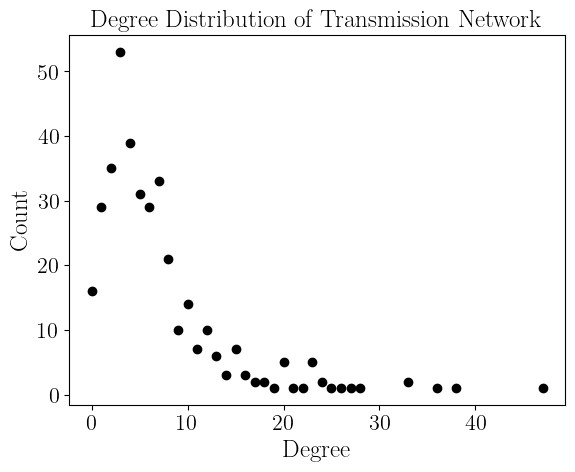

In [6]:
#Degree Distribution for the Graph

degrees = {}
for node,degree in graph_part2.degree:
    if degree in degrees.keys():
       degrees[degree] += 1 
    else:
        degrees[degree] = 1
        
        
plt.scatter(degrees.keys(),degrees.values(), color="black")
plt.title("Degree Distribution of Transmission Network", fontsize = 18)
plt.xlabel("Degree", fontsize = 18)
plt.ylabel("Count", fontsize = 18)

159.13333333333333
127.06666666666666
69.6
117.66666666666667


Text(0.02, 0.5, 'Population')

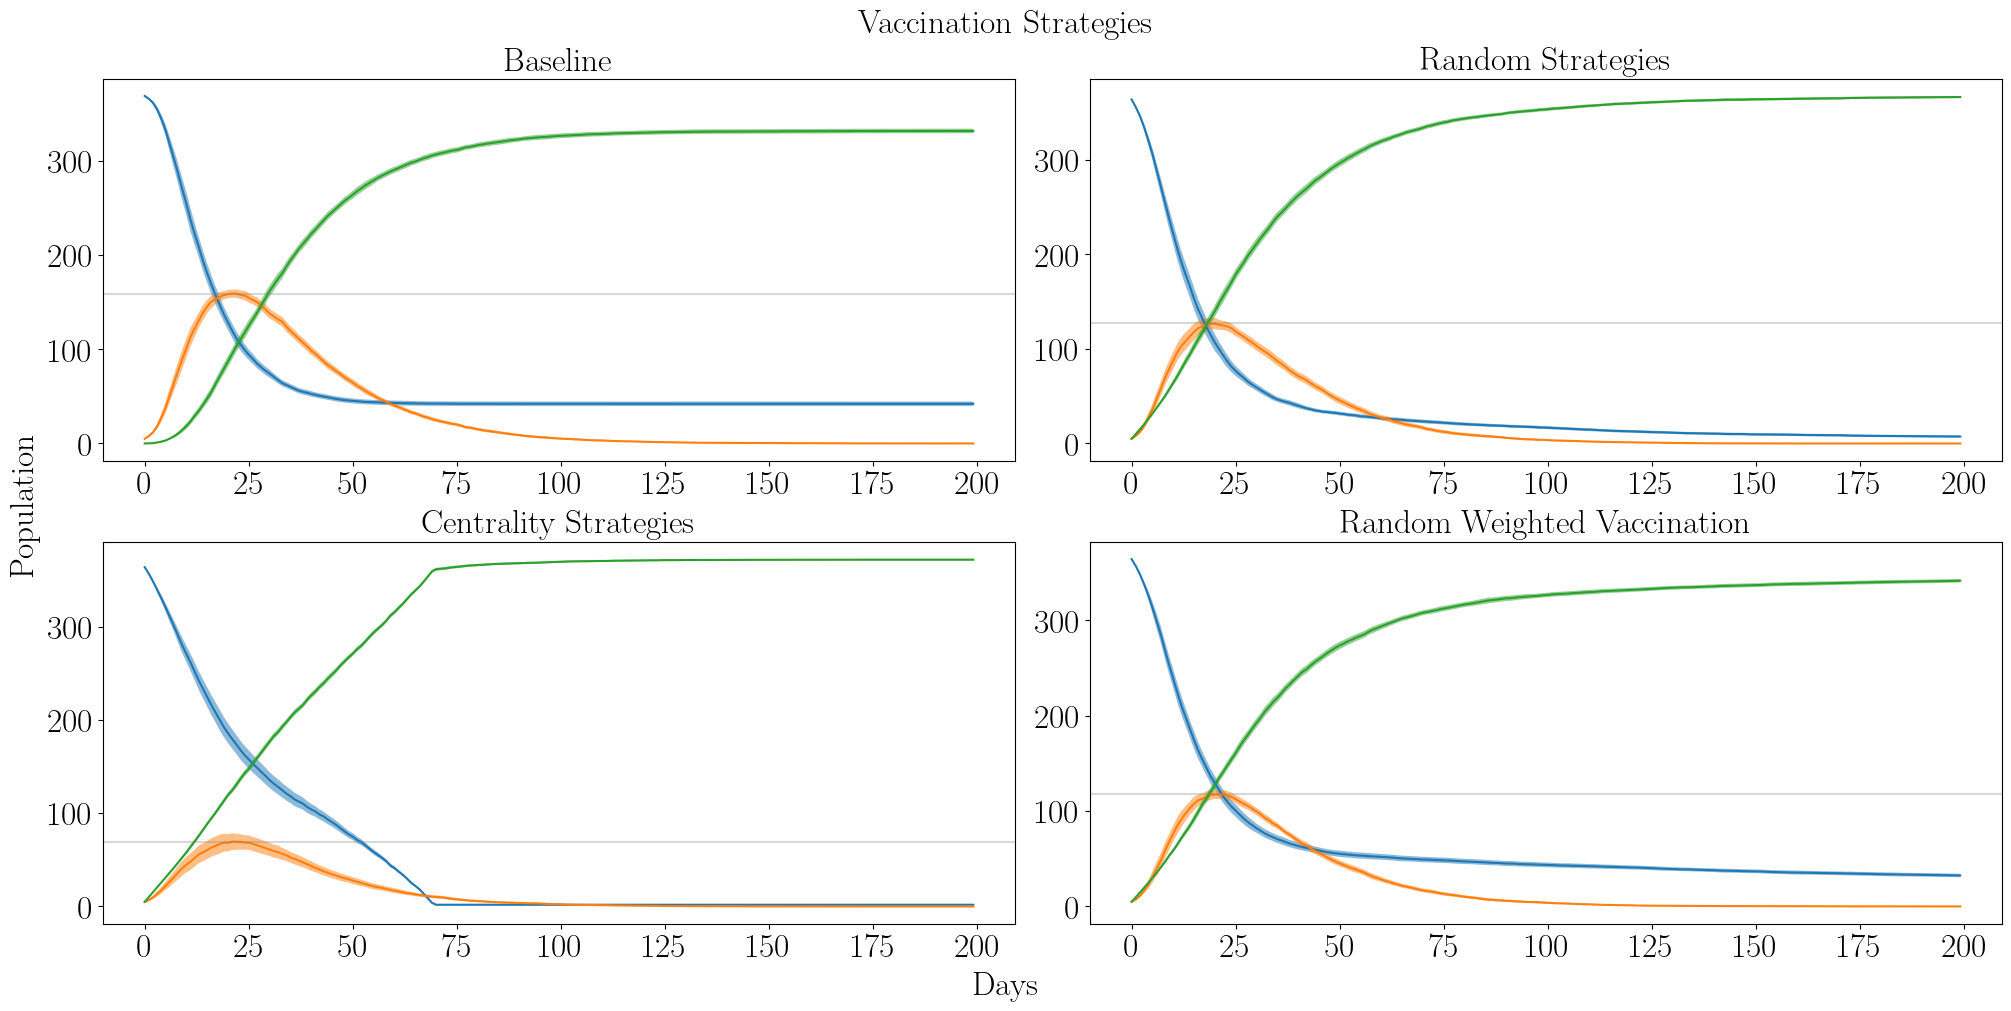

In [10]:
#Comparing SIR Spread with each Vaccination Strategy

np.random.seed(123)
f = pd.read_csv("transmission_network.csv", header=0, index_col=0, delimiter=";")
# Removing the weights
for column in f.columns:
    f[column] = [1 if x else 0 for x in f[column]]
graph_part2 = nx.Graph(f.values)

def random_vaccination(simulation):
    available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible"]
    if available:
        simulation.vaccine_targets = np.random.choice(available, size=simulation.vaccines)
        
def random_testing(simulation, accuracy=1):
    testing = np.random.choice(simulation.graph.nodes(), size= simulation.testIter)
    for node in testing:
        actual_status = ["Susceptible", "Infected", "Recovered"][simulation.model.status[node]] ## Poor man's dictionary
        test_result = np.random.choice([actual_status, "Susceptible"], size=1, p=[accuracy, 1-accuracy])[0]
        simulation.graph.nodes()[node]["check"] = test_result
        simulation.tests -= 1

def centrality_testing(simulation, accuracy=1):
    available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history]

    testing = sorted(simulation.graph.degree(), key=lambda x: x[1], reverse=True)
    testing = [node for node,_ in testing if node in available]
    for node in testing[:simulation.testIter]:
        actual_status = ["Susceptible", "Infected", "Recovered"][simulation.model.status[node]] ## Poor man's dictionary
        test_result = np.random.choice([actual_status, "Susceptible"], size=1, p=[accuracy, 1-accuracy])[0]
        simulation.graph.nodes()[node]["check"] = test_result
        simulation.tests -= 1

## Centrality measures
def centrality_vaccination(simulation):
    available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history]
    
    targets = sorted(simulation.graph.degree(), key=lambda x: x[1], reverse=True)
    available_target = [node for node,_ in targets if node in available]
    simulation.vaccine_targets = available_target[:simulation.vaccines]
    
def number_of_S_neighbor(simulation, node):
    return sum([1 for x in simulation.graph.neighbors(node) if simulation.graph.nodes[x]["check"] == "Susceptible"])

def random_weighted_vaccination(simulation):
    available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible"]
    if available:
        neighbors = [number_of_S_neighbor(simulation,x)for x in available]
        total = sum(neighbors)
        weights = [x/total for x in neighbors]
        simulation.vaccine_targets = np.random.choice(available, size=simulation.vaccines, p=weights)
        
kwargs = {
    "graph": graph_part2,
    "iterations": 200,
    "tests": 200,
    "testIter": 10,
    "accuracy": 1,
    "vaccines": 5,
    "infected": 5,
    "beta": 1/10,
    "gamma": 1/20,
    "vaccination_strat": baseline,
    "testing_strat": baseline,  
}
runs = 30
fig,ax = plt.subplots(2,2, figsize=(20,10), layout="constrained")
plt.rc('axes', titlesize=24)    
plt.rc('axes', labelsize=24)    
plt.rc('xtick', labelsize=24)   
plt.rc('ytick', labelsize=24)    
plt.rc('legend', fontsize=24)

ax = ax.ravel()
# 
sim = Simulation(**kwargs)

sim.setup_model()
base_data = sim.run(runs)
plot_data(base_data, ax[0], 90, "Baseline", individual=False)

kwargs["vaccination_strat"] = random_vaccination
kwargs["testing_strat"] = random_testing
sim = Simulation(**kwargs)
sim.setup_model()
random_data = sim.run(runs)
plot_data(random_data, ax[1], 90, "Random Strategies", individual=False)
# 
kwargs["vaccination_strat"] = centrality_vaccination
kwargs["testing_strat"] =  centrality_testing
sim = Simulation(**kwargs)
sim.setup_model()
closeness_data = sim.run(runs)
plot_data(closeness_data, ax[2], 90, "Centrality Strategies", individual=False)

kwargs["vaccination_strat"] = random_weighted_vaccination
kwargs["testing_strat"] = centrality_testing 
sim = Simulation(**kwargs)
sim.setup_model()
random_data = sim.run(runs)
plot_data(random_data, ax[3], 90, "Random Weighted Vaccination", individual=False)
fig.suptitle("Vaccination Strategies", fontsize = 24)
fig.supxlabel("Days", fontsize = 24)
fig.supylabel("Population", fontsize = 24)


68.53333333333333
68.83333333333333
66.0
61.36666666666667


Text(0.02, 0.5, 'Population')

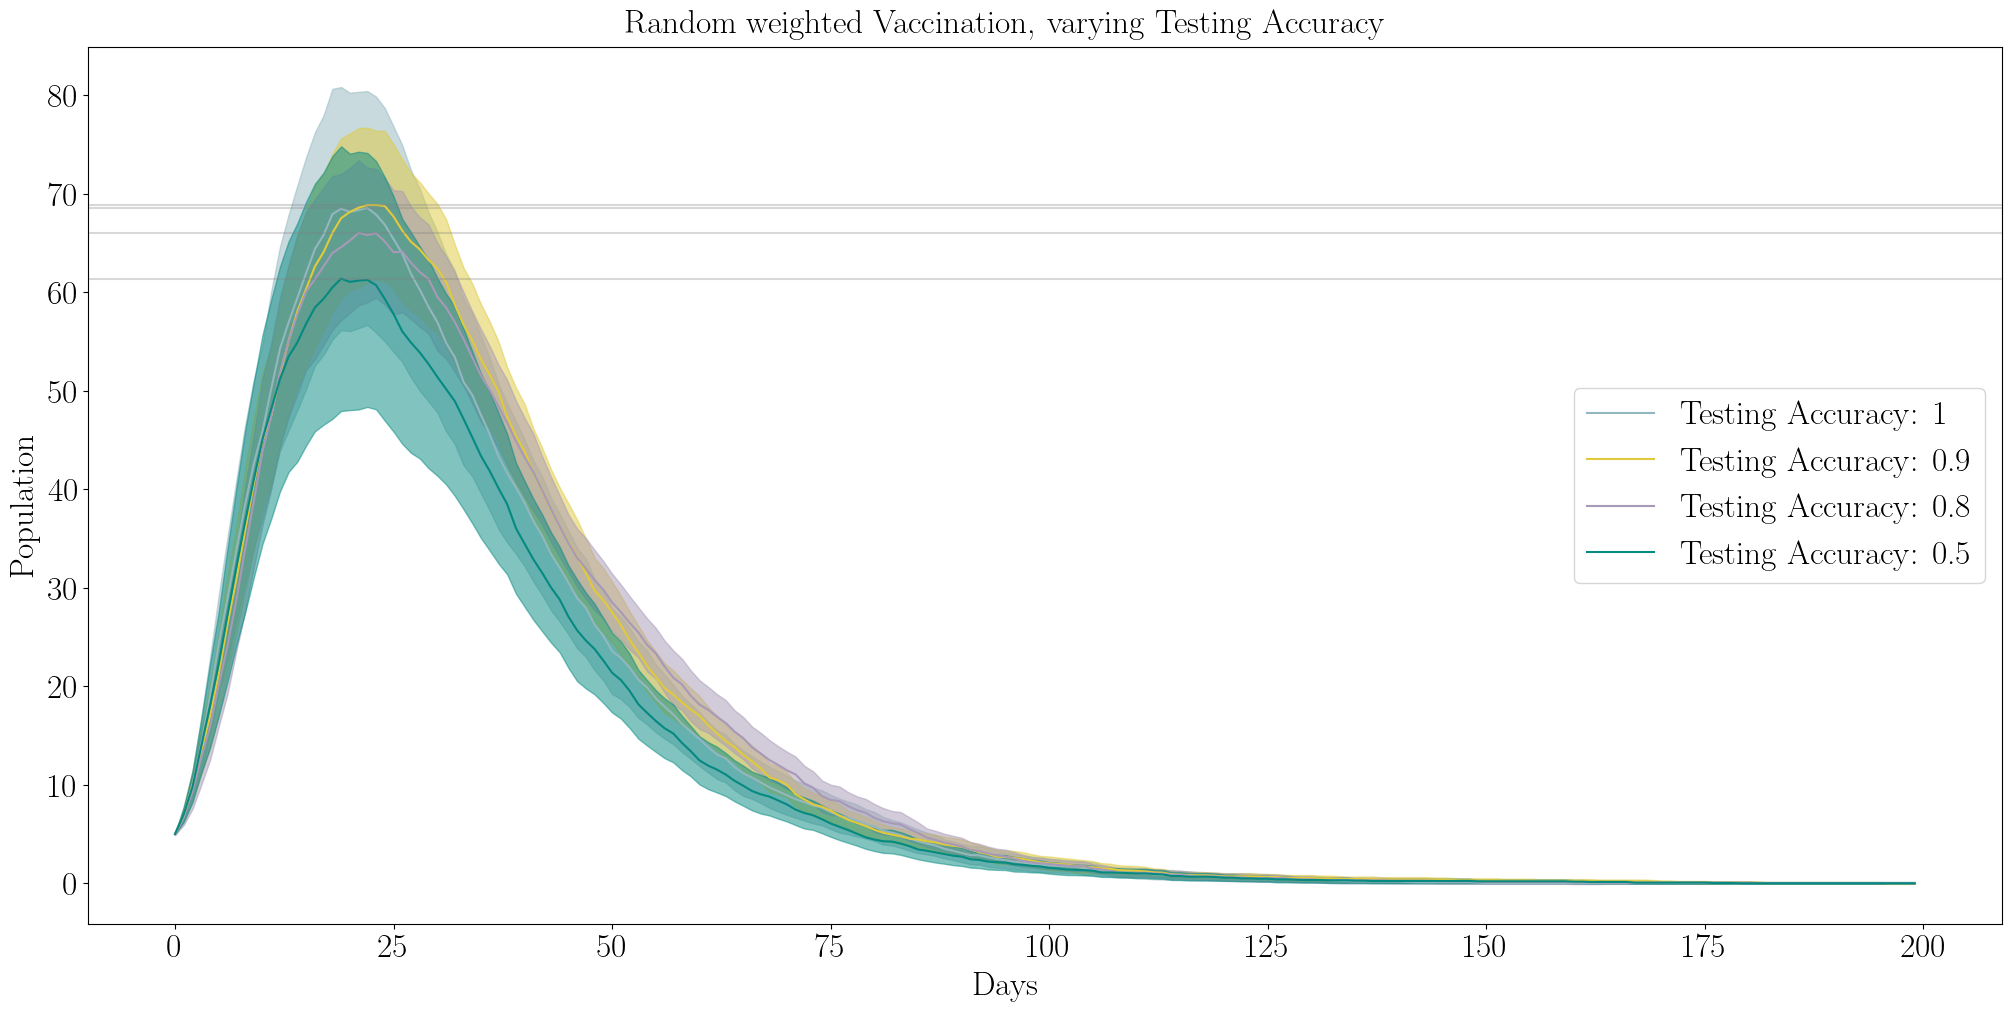

In [11]:
#Comparing Testing Strategies


kwargs = {
    "graph": graph_part2,
    "iterations": 200,
    "tests": 200,
    "testIter": 10,
    "accuracy": 1,
    "vaccines": 5,
    "infected": 5,
    "beta": 1/10,
    "gamma": 1/20,
    "vaccination_strat": centrality_vaccination,
    "testing_strat": centrality_testing,
}
np.random.seed(123)
runs=30
fig,ax = plt.subplots(1,1, figsize=(20,10), layout="constrained")

# ax = ax.ravel()
for i,accuracy in [(0,1),(1,0.9),(2,0.8),(3,.5)]:
    kwargs["accuracy"] = accuracy
    sim = Simulation(**kwargs)
    sim.setup_model()
    random_data = sim.run(runs)
     
    stackedplot_data(random_data, ax, 90, f"Testing Accuracy: {accuracy}", individual=False, color = i)
ax.legend(loc="best")
fig.suptitle("Random weighted Vaccination, varying Testing Accuracy", fontsize = 24)
fig.supxlabel("Days", fontsize = 24)
fig.supylabel("Population", fontsize = 24)

139.63333333333333
104.26666666666667
74.5
22.633333333333333


Text(0.02, 0.5, 'Infected Population')

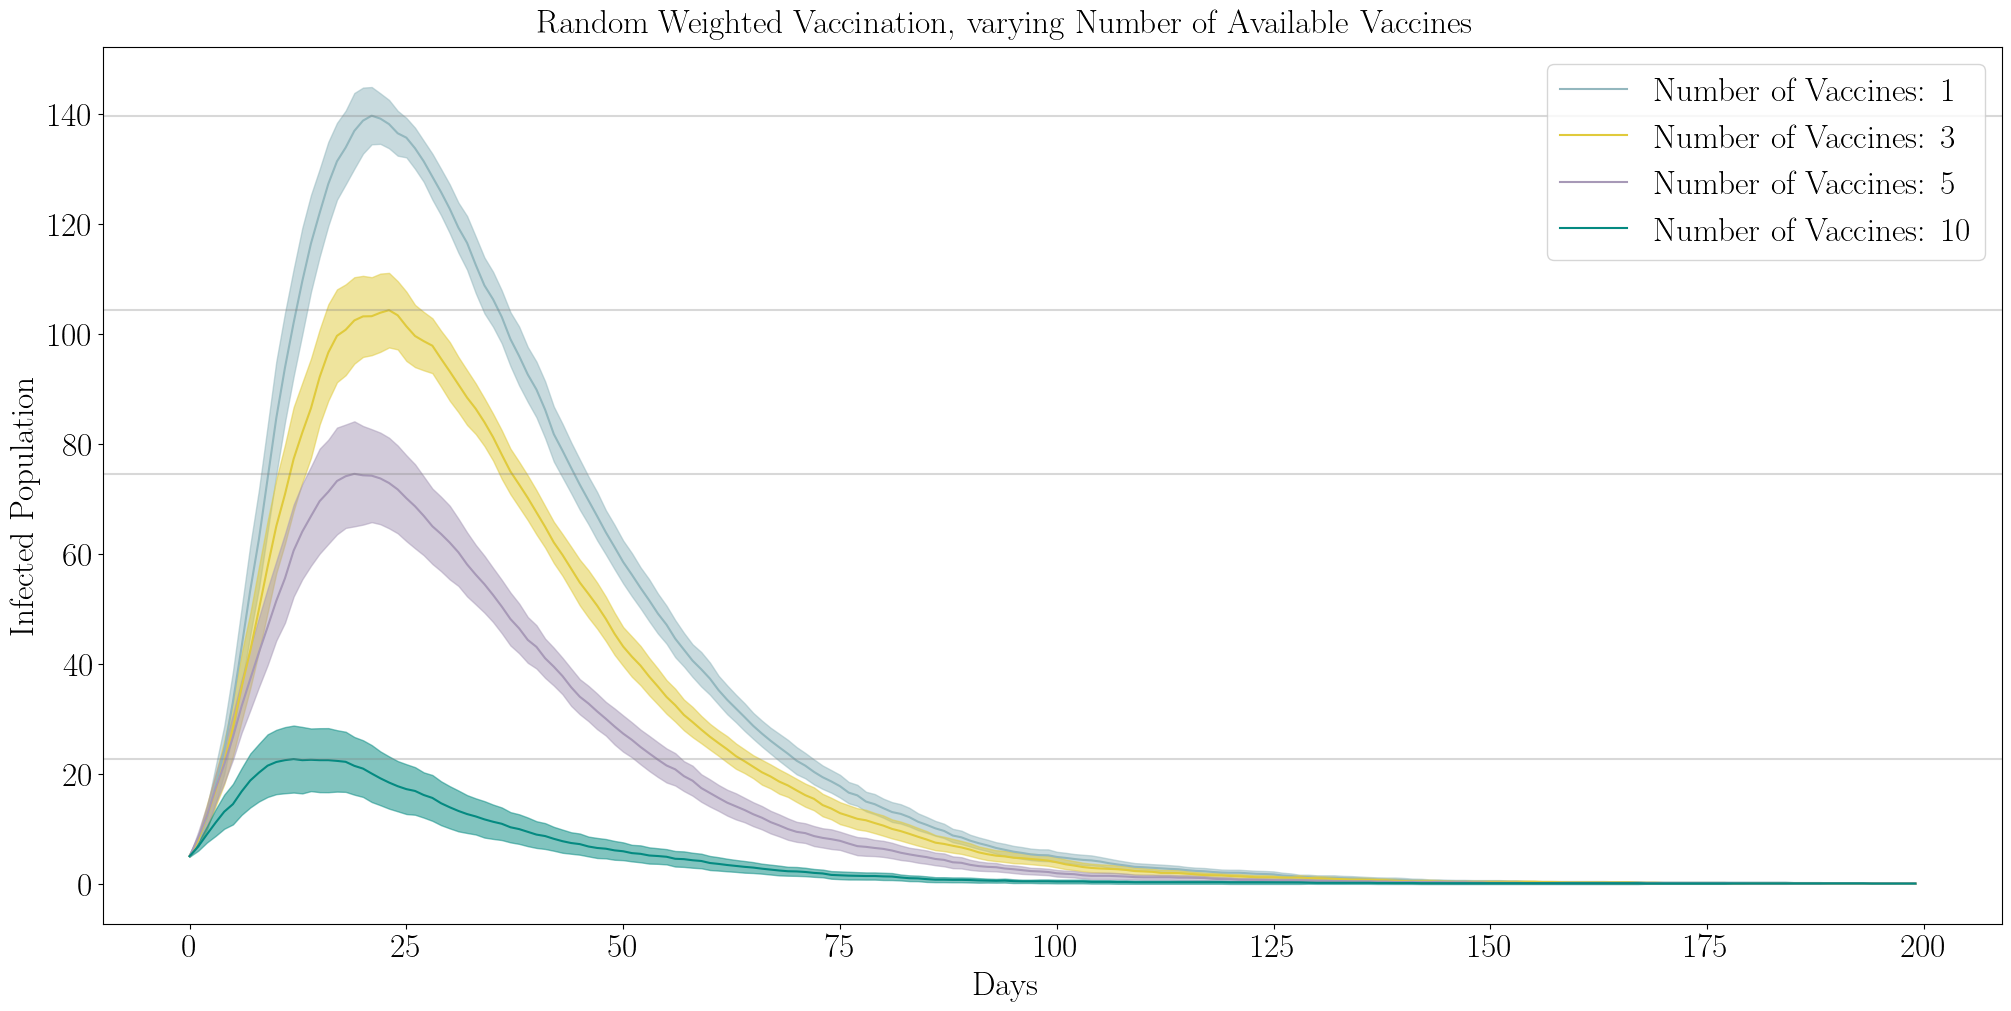

In [12]:
#Comparing Vaccination with Varying Vaccine Availability

kwargs = {
    "graph": graph_part2,
    "iterations": 200,
    "tests": 200,
    "testIter": 10,
    "accuracy": 1,
    "vaccines": 10,
    "infected": 5,
    "beta": 1/10,
    "gamma": 1/20,
    "vaccination_strat": centrality_vaccination,
    "testing_strat": centrality_testing,
}
np.random.seed(123)
runs = 30
fig,ax = plt.subplots(1,1, figsize=(20,10), layout="constrained")

for i,vaccines in [(0,1),(1,3),(2,5),(3,10)]:
    kwargs["vaccines"] =vaccines 
    sim = Simulation(**kwargs)
    sim.setup_model()
    random_data = sim.run(runs)

    stackedplot_data(random_data, ax, 0, f"Number of Vaccines: {vaccines}", individual=False, color=i)
ax.legend(loc="best")
fig.suptitle("Random Weighted Vaccination, varying Number of Available Vaccines", fontsize = 24)
fig.supxlabel("Days", fontsize = 24)
fig.supylabel("Infected Population", fontsize = 24)